In [146]:
import ssdeep
import pickle,os,sys,gc
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from tqdm import tqdm
from collections import Counter
import multiprocessing as mp
from multiprocessing import Process, Manager, Pool
import time,datetime
from itertools import chain
import math
from operator import itemgetter
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from scipy.cluster.hierarchy import dendrogram, linkage


In [147]:
#  import sys,os
print(sys.executable)
print(sys.version)
print(sys.version_info)
import findspark
# os.environ['PYSPARK_PYTHON'] = '/usr/bin/python3' #'/home/antslab/anaconda3/bin/python'
findspark.init()
import pyspark
# from pyspark import SparkContext
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import Row, SQLContext, SparkSession, window
from pyspark import SparkConf, SparkContext
# Import data types
from pyspark.sql.types import *
import  pyspark.sql.functions as F
conf = SparkConf()
# conf.set("spark.local.dir", "/mnt/ssd240g/data/Leo_Spark_Home/tmp")
conf.set("spark.executor.cores","12")
conf.setMaster("local[12]")
conf.set("spark.driver.memory","85g")
conf.set("spark.executor.memory", "95g")
conf.set("spark.memory.offHeap.enabled","true")
conf.set("spark.memory.offHeap.size","85g")
conf.set("spark.driver.extraJavaOptions","-Xss80g")
conf.set("spark.driver.extraJavaOptions","-Xms80g")
# conf.set("spark.memory.storageFraction","0.2")
# conf.set("spark.driver.maxResultSize","0")
# conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
# conf.set("spark.sql.execution.arrow.enabled", "true")
conf.set("spark.kubernetes.pyspark.pythonVersion","3")
conf.set("spark.sql.shuffle.partitions",100000)
conf.set("spark.driver.maxResultSize", "150g")

# spark = SparkSession.builder.appName("pcap_analyzer").config(conf=conf).getOrCreate() #pcap_analyzer pcapAnalyzer
spark = SparkSession.builder.master("local").appName("Test_spark").config(conf=conf).getOrCreate()
# spark.conf.set("spark.sql.execution.arrow.enabled", True)
spark.conf.set("spark.sql.debug.maxToStringFields", 290000)
spark.conf.set("spark.sql.hive.filesourcePartitionFileCacheSize",100*1024*1024*1024)

import databricks.koalas as ks
ks.options.display.max_rows = 20
ks.set_option('compute.max_rows', None)
# ks.set_option('compute.ops_on_diff_frames', True)
ks.set_option('compute.default_index_type', 'distributed')
print(ks.__version__)
spark.version

/home/antslab/anaconda3/bin/python
3.7.7 (default, Mar 26 2020, 15:48:22) 
[GCC 7.3.0]
sys.version_info(major=3, minor=7, micro=7, releaselevel='final', serial=0)
1.0.1


'3.0.0'

In [148]:
in_file = "/home/antslab/data_hdd4t/pcap_process/pcap_spark/2020_01_10/中華電信/parquet/2020_01_10_session_v7-2_hashpayload_time_size.parquet"
pickle_dir = '/home/antslab/spark_data/pcap_inter/2020_01_10/中華電信/case_pickles/'
picture_dir = '/home/antslab/spark_data/pcap_inter/2020_01_10/中華電信/case_pictures/'

In [149]:
if not os.path.exists(pickle_dir):
    os.makedirs(pickle_dir,exist_ok=True)
if not os.path.exists(picture_dir):
    os.makedirs(picture_dir,exist_ok=True)    
df = ks.read_parquet(in_file)
print(df.columns)
df = df[['session_time','session_time_list','session_duration','session_tt_packet', 'session_i_tt_packet', 'session_o_tt_packet',
             'session_tt_frame_length', 'session_i_tt_frame_length','session_o_tt_frame_length','udp_tt_length', 'udp_i_tt_length',
             'udp_o_tt_length', 'udp_i_avg_length', 'udp_o_avg_length','icmp_i_avg_length', 'icmp_o_avg_length',
             'icmp_tt_original_datagram_length', 'icmp_i_tt_datagram_length','icmp_o_tt_datagram_length', 'icmp_i_avg_datagram_length',
             'icmp_o_avg_datagram_length','tcp_tt_payload_length', 'tcp_i_tt_payload_length','tcp_o_tt_payload_length', 'tcp_i_avg_payload_length',
             'tcp_o_avg_payload_length','ip_src', 'ip_dst','tcp_srcport', 'tcp_dstport', 'udp_srcport', 'udp_dstport', 'country',
             'city', 'subdivisions','domain','isp','frame_i_common_protocols','frame_o_common_protocols', 'frame_i_max_protocols','frame_o_max_protocols', 'tcp_i_payload_list', 'tcp_o_payload_list'        
            ]]
# df['tcp_payload_avg'] = df.tcp_payload_size/df.session_packets
# df['udp_payload_size'] = df.udp_length_sum - (df.session_packets*8)
# df['udp_payload_avg'] = df.udp_payload_size/df.session_packets
# df['icmp_payload_avg'] = df.icmp_length_original_datagram_sum/df.session_packets

 #50461592 
gc.collect()
# df

Index(['session_time', 'session_time_list', 'session_duration',
       'session_tt_packet', 'session_i_tt_packet', 'session_o_tt_packet',
       'session_tt_frame_length', 'session_i_tt_frame_length',
       'session_o_tt_frame_length', 'udp_tt_length', 'udp_i_tt_length',
       'udp_o_tt_length', 'udp_i_avg_length', 'udp_o_avg_length',
       'icmp_tt_length', 'icmp_i_tt_length', 'icmp_o_tt_length',
       'icmp_i_avg_length', 'icmp_o_avg_length',
       'icmp_tt_original_datagram_length', 'icmp_i_tt_datagram_length',
       'icmp_o_tt_datagram_length', 'icmp_i_avg_datagram_length',
       'icmp_o_avg_datagram_length', 'tcp_hdr_len_sum',
       'tcp_tt_payload_length', 'tcp_i_tt_payload_length',
       'tcp_o_tt_payload_length', 'tcp_i_avg_payload_length',
       'tcp_o_avg_payload_length', 'ip_avg_ttl', 'ip_max_ttl',
       'tcp_avg_window', 'tcp_max_window', 'ip_src', 'ip_dst', 'ip_proto',
       'tcp_srcport', 'tcp_dstport', 'udp_srcport', 'udp_dstport', 'country',
       'city', '

1589

In [150]:
 #篩選出有in bound payload的session
df1 = df[(df.session_duration>0.1)&(df.session_i_tt_packet>1)&(df.session_i_tt_frame_length>0)&
         (df.tcp_i_payload_list.astype(str)!='[]')]
df1 = df1[(df1.udp_i_tt_length>0)|(df1.udp_i_avg_length>0)|(df1.icmp_i_avg_length>0)|
        (df1.icmp_i_tt_datagram_length>0)|(df1.tcp_i_tt_payload_length>0)|(df1.tcp_i_avg_payload_length>0)]
gc.collect()
# df1

960

In [ ]:
df2 = df1[(df1.tcp_o_payload_list.astype(str)!='[]')&(df1.session_o_tt_packet>0)&(df1.session_o_tt_frame_length>0)]
df2 = df2[(df2.udp_o_tt_length>0)|(df2.udp_o_avg_length>0)|(df2.icmp_o_avg_length>0)|
        (df2.icmp_o_tt_datagram_length>0)|(df2.tcp_o_tt_payload_length>0)|(df2.tcp_o_avg_payload_length>0)]
df2 = df2[(df2.domain != 'googlebot.com')|(df2.isp!='Googlebot')]
gc.collect()
df2 = df2.to_pandas()
df2

In [ ]:
print("所有protocol總和中，1.原本的session總數:",len(df)," 2.in-bound具有payload的sessiony總數:",len(df1)," 3.in-與out-bound都具有payload的session總數(最終拿來進行分群的sessions):",len(df2))

In [ ]:
print(df2.frame_i_max_protocols.value_counts().head(60))
print(df2.frame_o_max_protocols.value_counts().head(60))
print(df2.domain.value_counts().head(60))
df2.isp.value_counts().head(60)

In [188]:
# case protocol study
ip_li = ['5.188.211.35','5.188.210.65','213.87.148.112','172.80.253.50','203.150.154.191',
         '149.129.50.37','106.12.69.27','109.169.21.204','195.154.200.161','94.23.20.187',
         '200.255.122.170','173.82.105.53']
for ip in ip_li:
    print(ip,':',df[df.ip_src == ip].frame_i_max_protocols.unique().to_numpy())

5.188.211.35 : ['eth:ethertype:ip:tcp' 'eth:ethertype:ip:tcp:http:urlencoded-form'
 'eth:ethertype:ip:tcp:http']
5.188.210.65 : ['eth:ethertype:ip:tcp:http' 'eth:ethertype:ip:tcp'
 'eth:ethertype:ip:tcp:http:urlencoded-form']
213.87.148.112 : ['eth:ethertype:ip:tcp:http']
172.80.253.50 : ['eth:ethertype:ip:tcp:http:data' 'eth:ethertype:ip:icmp:data'
 'eth:ethertype:ip:tcp:http:urlencoded-form' 'eth:ethertype:ip:tcp']
203.150.154.191 : ['eth:ethertype:ip:tcp:http' 'eth:ethertype:ip:tcp']
149.129.50.37 : ['eth:ethertype:ip:tcp' 'eth:ethertype:ip:tcp:http']
106.12.69.27 : ['eth:ethertype:ip:tcp' 'eth:ethertype:ip:tcp:http'
 'eth:ethertype:ip:tcp:http:data'
 'eth:ethertype:ip:tcp:http:urlencoded-form:data'
 'eth:ethertype:ip:tcp:http:urlencoded-form']
109.169.21.204 : ['eth:ethertype:ip:tcp:http:data' 'eth:ethertype:ip:tcp']
195.154.200.161 : ['eth:ethertype:ip:tcp:mysql' 'eth:ethertype:ip:tcp:http']
94.23.20.187 : ['eth:ethertype:ip:tcp:ftp' 'eth:ethertype:ip:tcp'
 'eth:ethertype:ip:tcp:h

In [317]:
case_df = df2[(df2.ip_src == '106.12.69.27')&(df2.frame_i_max_protocols.str.contains('http'))]
time_li = case_df.session_time_list.tolist()
time_li = [list(x) for x in time_li]
pickle.dump(obj=time_li,file=open(pickle_dir+"106.12.69.27_timelist_http.pkl",'wb'))
print(len(time_li))
case_df

10


,session_time,session_time_list,session_duration,session_tt_packet,session_i_tt_packet,session_o_tt_packet,session_tt_frame_length,session_i_tt_frame_length,session_o_tt_frame_length,udp_tt_length,udp_i_tt_length,udp_o_tt_length,udp_i_avg_length,udp_o_avg_length,icmp_i_avg_length,icmp_o_avg_length,icmp_tt_original_datagram_length,icmp_i_tt_datagram_length,icmp_o_tt_datagram_length,icmp_i_avg_datagram_length,icmp_o_avg_datagram_length,tcp_tt_payload_length,tcp_i_tt_payload_length,tcp_o_tt_payload_length,tcp_i_avg_payload_length,tcp_o_avg_payload_length,ip_src,ip_dst,tcp_srcport,tcp_dstport,udp_srcport,udp_dstport,country,city,subdivisions,domain,isp,frame_i_common_protocols,frame_o_common_protocols,frame_i_max_protocols,frame_o_max_protocols,tcp_i_payload_list,tcp_o_payload_list
6053965,1.578627e+09,"[1578627055.842613, 1578627055.842792, 1578627...",0.170523,10,6,4,1280,562.0,718.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,628.0,182.0,446.0,30.333333,111.500000,106.12.69.27,210.242.145.122,32860.0,80.0,NaN,NaN,China,Shanghai,Shanghai,None,Beijing Baidu Netcom Science and Technology Co.,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http,eth:ethertype:ip:tcp:http:data-text-lines:xml,[[12:GtE/H2U/g+aHT+a8k4XIWpNECO4XIWpNECR72sNEY...,"[[3:KD+U/kIgfFf+S5aPS:KKAk7flea, 1578627055.93..."
14382311,1.578626e+09,"[1578625637.9666, 1578625637.968579, 157862563...",0.959912,10,5,5,1431,1027.0,404.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,779.0,713.0,66.0,142.600000,13.200000,106.12.69.27,210.242.146.150,43616.0,80.0,NaN,NaN,China,Shanghai,Shanghai,None,Beijing Baidu Netcom Science and Technology Co.,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http:data,eth:ethertype:ip:tcp:http,[[48:te4nVjhjjhX3QBFqFoauuZbMMzmD18hw18hBt2qj5...,[[6:KKA7fXXX7Uj+SVXTBHE7RWf6Q9ZTR66T7Dhmn:KX7f...
20692536,1.578617e+09,"[1578617358.452822, 1578617358.453095, 1578617...",24.911304,14,8,6,15970,1086.0,14884.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15078.0,598.0,14480.0,74.750000,2413.333333,106.12.69.27,210.242.145.176,46382.0,80.0,NaN,NaN,China,Shanghai,Shanghai,None,Beijing Baidu Netcom Science and Technology Co.,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http:urlencoded-form,eth:ethertype:ip:tcp:http:data-text-lines,[[48:8faSgvX68Y18nFF9PfB/eBAMUxlHyUl4xlHyUNHay...,[[96:bYb4CvCp4QuQxr9KBjqozJnsnSnrnb01D0Fndpenu...
23466138,1.578595e+09,"[1578594918.125719, 1578594918.125985, 1578594...",0.194254,10,5,5,1520,1116.0,404.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,868.0,802.0,66.0,160.400000,13.200000,106.12.69.27,210.242.149.147,54110.0,80.0,NaN,NaN,China,Shanghai,Shanghai,None,Beijing Baidu Netcom Science and Technology Co.,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http,eth:ethertype:ip:tcp:http,[[48:/1M2xiyTkzVhKFSVjhjjhX3KaZMYVn18hw18ut1B6...,[[6:KKA7fXXX7Uj+SVXTBHE7RWf6Q9ZTR66T7Dhmn:KX7f...
35581929,1.578591e+09,"[1578591113.808755, 1578591113.809026, 1578591...",0.480692,11,6,5,1335,551.0,784.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,617.0,171.0,446.0,28.500000,89.200000,106.12.69.27,210.242.146.114,50992.0,80.0,NaN,NaN,China,Shanghai,Shanghai,None,Beijing Baidu Netcom Science and Technology Co.,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http:data,eth:ethertype:ip:tcp:http:data-text-lines:xml,[[12:iHLmHXq6xcQqFpNAk4XIWpNECO4XIWpNECR72sNEY...,"[[3:KD+U/kIgfFf+S5aPS:KKAk7flea, 1578591114.20..."
37348229,1.578586e+09,"[1578585754.264546, 1578585754.264699, 1578585...",1.310619,11,6,5,1710,926.0,784.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,992.0,546.0,446.0,91.000000,89.200000,106.12.69.27,210.242.146.81,44080.0,80.0,NaN,NaN,China,Shanghai,Shanghai,None,Beijing Baidu Netcom Science and Technology Co.,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http:urlencoded-form:data,eth:ethertype:ip:tcp:http:data-text-lines:xml,[[48:8+BguvaC06HtMz2qsyhOY18nmVjhjjhX3B:8+OnzS...,"[[3:KD+U/kIgfFf+S5aPS:KKAk7flea, 1578

In [ ]:
protocol_name = 'tds'
df2_tds = df2[(df2.frame_i_max_protocols.str.contains(protocol_name))&(df2.frame_o_max_protocols.str.contains(protocol_name))]
df2_tds

### Function

In [ ]:
 
def prepare_df(df2,protocol_name='http',split="size",loner=False):
    protocol_name = str(protocol_name).lower()
    '''
    df2: filterout no payload's all sessions df
    protocol_name: what TCP protocol string would be contained e.g., smb,http,tds...
    loner: 用來檢查不同天相同protocol的分群
    
    return1: protocol original dataframe (session-based)
    return2: protocol payload dataframe (packet-based)
    '''
    def sort_fn(data):
        '''
        sort by time: itemgetter(1)
        sort by size: itemgetter(2)
        '''
        if split=='size':
            return sorted(data,key=itemgetter(2))
        elif split == 'time':
            return sorted(data,key=itemgetter(1))
                    
    def split_col_len(session):
        '''
        input: list(session) of lists(packets) =>tuple=(hash,time)

        Return1: list of ssdeep length
        Return2: list of session's packets hashes
        '''
    #     for session in payload_li:
#         packet_payload = []
        packet_len = []
        for packet in session:
            ssdeep_hash = packet[0]
    #         packet_payload.append(ssdeep_hash)
            packet_len.append(ssdeep_hash.split(':')[0])
        return packet_len#,packet_payload

    def split_col_hash(session):
        '''
        input: list(session) of lists(packets) =>tuple=(hash,time)

        Return1: list of ssdeep length
        Return2: list of session's packets hashes
        '''
    #     for session in payload_li:
        packet_payload = []
#         packet_len = []
        for packet in session:
            ssdeep_hash = packet[0]
            packet_payload.append(ssdeep_hash)
    #         packet_len.append(ssdeep_hash.split(':')[0])
        return packet_payload
    if not loner:
        df2_protocol = df2[(df2.frame_i_max_protocols.str.contains(protocol_name))&(df2.frame_o_max_protocols.str.contains(protocol_name))]
    else:
        df2_protocol = df2
    df2_protocol_payload = df2_protocol[['tcp_i_payload_list']]
    df2_protocol_payload['tcp_i_payload_list'] = df2_protocol_payload.tcp_i_payload_list.map(sort_fn)
    df2_protocol_payload['size'] = df2_protocol_payload.tcp_i_payload_list.map(split_col_len) #,df2_protocol_payload['hash']
    df2_protocol_payload['hash'] = df2_protocol_payload.tcp_i_payload_list.map(split_col_hash)
    L_size = [x if isinstance(x, list) else [x] for x in df2_protocol_payload['size']]
    L_hash = [x if isinstance(x, list) else [x] for x in df2_protocol_payload['hash']]
    df2_protocol_payload = pd.DataFrame({
        'idx':df2_protocol_payload.index.values.repeat([len(x) for x in L_size]),
        'size':list(chain.from_iterable(L_size)),
        'hash':list(chain.from_iterable(L_hash))
        })
    # df2_protocol_payload['idx'] = 
    df2_protocol_payload['size'] = df2_protocol_payload['size'].astype(int)
    if not loner:
        return df2_protocol, df2_protocol_payload
    else:
        return df2_protocol_payload

In [ ]:
def similarity_compare(df2_protocol,df2_protocol_payload,ori_protocol=None,ori_protocol_payload=None,thr=0,thr2=10,loner=False): #40
    '''
    GOAL: compare with timestamp's q1,q2,q3 to similar size packet. Pick max value for score.
    df2_protocol: protocol original dataframe (session-based)
    df2_protocol_payload: protocol payload dataframe (packet-based)
    loner:需指派ori_protocol、ori_protocol_payload
    
    Return: dictionary with each cluster 
    '''
    def ssdeep_compare(target_hash,candidate_df):
        '''
        Input1: string of hash
        Input2: dataframe of candidate
        '''
        def compare(candidate_hash):
            return ssdeep.compare(target_hash,candidate_hash)
        return candidate_df.hash.map(compare)
    big_dict_protocol = {}
    big_dict_protocol_score = {}
#     big_dict_protocol2 = {} #test
    used_idx_li = []
    all_scores = [] #test2
    for idx in tqdm(df2_protocol.index):
        if idx in used_idx_li:
            continue
        target = df2_protocol_payload[df2_protocol_payload.idx == idx]
        target = target.reset_index(drop=True)
        t_len = len(target)
        q1 = int(t_len*0.25)
        q2 = int(t_len*0.5)
        t_q1 = target.iloc[q1,-1]
        if not loner:
            candidate = df2_protocol_payload[df2_protocol_payload.idx!=idx]
            candidate = candidate[~candidate.idx.isin(used_idx_li)] #candidat不可重複分群
        else:
            t_ip = df2_protocol[df2_protocol.index == idx].ip_src.values[0]
            candidate_idx = ori_protocol[ori_protocol.ip_src == t_ip].index.tolist()
            candidate = ori_protocol_payload[ori_protocol_payload.idx.isin(candidate_idx)] #可重複分群?
        
        candidate['idx'] = candidate.idx.astype(str)
#         candidate_q1 = candidate[candidate['size']==target.iloc[q1,-2]] #rule
        candidate['q1'] = ssdeep_compare(t_q1,candidate) #rule:candidate_q1
        if q2 != q1:
            t_q2 = target.iloc[q2,-1]
            q3 = int(t_len*0.75)
#             candidate_q2 = candidate[candidate['size']==target.iloc[q2,-2]] #rule
            candidate['q2'] = ssdeep_compare(t_q2,candidate) #rule:candidate_q2
            if q3 != q2:
                t_q3 = target.iloc[q3,-1]
#                 candidate_q3 = candidate[candidate['size']==target.iloc[q3,-2]] #rule
                candidate['q3'] = ssdeep_compare(t_q3,candidate) #rule:candidate_q3
                if t_len>4:
#                     t_min = target.iloc[0,-1] 
#                     candidate['min'] = ssdeep_compare(t_min,candidate)
                    t_max = target.iloc[-1,-1]
                    candidate['max'] = ssdeep_compare(t_max,candidate)
                    
        candidate = candidate.drop(['size','hash'],axis=1)
        candidate['score'] = candidate.mean(axis=1) #max
        score_li = candidate.score.tolist() #test2
        candidate = candidate[candidate.score>thr] #相似度分數，數字越小速度愈快、數字越大越多群
        candidate['idx'] = candidate.idx.astype(int)
#         candidate2 = candidate[candidate.score<thr2] #test
        idx_li = list(set(candidate.idx.tolist()))
#         idx_li2 = list(set(candidate2.idx.tolist())) #test
        all_scores.extend(score_li) #test2
        if len(idx_li)>0:
            
            used_idx_li.extend(idx_li)
            used_idx_li.append(idx)
            if not loner:
                big_dict_protocol[idx] = idx_li
                big_dict_protocol_score[idx] = candidate.score.tolist()
            else:
                big_dict_protocol[t_ip+'_'+str(idx)] = idx_li
                big_dict_protocol_score[t_ip+'_'+str(idx)] = candidate.score.tolist()                
#         if len(idx_li2)>0: #test
#             big_dict_protocol2[idx] = idx_li2 # test
    return big_dict_protocol,sorted(list(set(df2_protocol.index)-set(used_idx_li))),all_scores,big_dict_protocol_score #test

In [ ]:
def write2pkl(df2_protocol,big_dict,cluster_key,case_id,path=pickle_dir):
    '''
    GOAL: output 3-tuple to draw time diagram
    df2_protocol: original dataframe session-based
    big_dict: big_dict_protocol
    cluster_key: print by find_cluster function
    case_id: user defined to identify
    '''
    cluster_key = int(cluster_key)
#     print(big_dict[cluster_key])
    temp_li = big_dict[cluster_key][:]
#     print(temp_li)
    temp_li.append(cluster_key) #最後一個session才是key (target)，其他人(candidates)都是跟他(target)比
#     print(temp_li)
#     temp_li = temp_li2[:]
    case_diagram = df2_protocol.loc[list(set(temp_li))]
    time_lists = case_diagram.session_time_list.tolist()
    time_lists = [list(x) for x in time_lists]
    ips = case_diagram.ip_src.tolist()
    countries = case_diagram.country.tolist()
    print('Unique Country#:',len(set(countries)),"Unique IP#:",len(set(ips)),'Session#:',len(time_lists))
    # pickle_dir = '/home/antslab/spark_data/pcap_inter/2020_01_10/中華電信/case_pickles/'
    pickle.dump(obj=(time_lists,ips,countries),file=open(path+'case#'+str(case_id)+'_threetuples.pkl','wb'))        


In [ ]:
def find_cluster(big_dict,idx):
    '''
    big_dict: big_dict_protocol
    idx: which idx want to find
    Return cluster id (big_dict"s key number')
    '''
    idx = int(idx)
    try:
        big_dict[idx] #KeyError
        return idx
    except KeyError:
        for k,v in big_dict.items():
            if idx in v:
                return k
                break

In [ ]:
def cluster_stat(protocol_big_dict,protocol_df,proto,date,drawlog=False):
    """
    GOAL: output statistic of certain protocol
    input1: dict from similarity_compare
    inpit2: df from prepare_df
    """
    
    all_nums = []
    clus_id = []
    # all_num = 0
    for k,v in protocol_big_dict.items():
    #     all_nums.extend(v)
        all_nums.append(len(v))
        clus_id.append(k)
    #     all_num +=len(v)
    clus_num = len(all_nums)
    print("原本總共sessions#:",len(protocol_df))
    print("共有#sessions可分群:",sum(all_nums)+clus_num,"共有#lonerSessions:",len(protocol_df)-(sum(all_nums)+clus_num))
    print("可分為#群:",clus_num)
#     print(sum(all_nums)+len(all_nums),len(protocol_df)-(sum(all_nums)+len(all_nums)),len(protocol_df))
    protocol_stat_df = pd.DataFrame(all_nums,index=clus_id)
    protocol_stat_df[0] = protocol_stat_df[0]+1
    print("前五大的cluster key與對應之群集大小\n",protocol_stat_df[0].nlargest(5))
    print(protocol_stat_df.describe())
    protocol_stat_df  = pd.DataFrame(all_nums,index=[x for x in range(len(all_nums))])
    protocol_stat_df.hist(bins=100)
    plt.savefig(picture_dir+str(proto)+'_'+str(date)+'_clustersize_hist'+'.png', dpi=300, format='png')
    
    temp = dict(Counter(all_nums))
    temp = {k: v for k, v in sorted(temp.items(), key=lambda item: item[0])}
#     temp = sorted(all_nums,reverse=True)
    x_axis = [k for k in temp.keys()] #群中所含的數量
    y_axis = [v for v in temp.values()] #該數量共有幾群為此
    plt.figure(figsize=(30,20),dpi=300,linewidth = 1) # 圖片大小、折線寬度
    plt.plot(x_axis,y_axis,'o-',color = 'b', label=proto) #折現的型態、折現的顏色
#     plt.title(, x=0.5, y=1.03)
    plt.figtext(.5,.9,str(date)+" "+str(proto)+" cluster# of cluster's size",fontsize=30,ha='center')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel("cluster size", fontsize=25, labelpad = 15)
    plt.ylabel("cluster #", fontsize=25, labelpad = 20)
    # plt.ylim(0, 2500)
    # plt.legend(loc = "best", fontsize=20)
    plt.savefig(picture_dir+str(proto)+'_'+str(date)+'_clusternumber_line'+'.png', dpi=300, format='png')
    plt.show()    
    
#log diagram
    fig, ax = plt.subplots()
    ax.set_yscale('log')
    protocol_stat_df.hist(ax=ax, bins=100, bottom=0.1)
    plt.savefig(picture_dir+str(proto)+'_'+str(date)+'_clustersize_hist_log'+'.png', dpi=300, format='png')
    
    return len(protocol_df)-(sum(all_nums)+clus_num),protocol_stat_df.describe()

In [ ]:
def cluster_rep_hash(proto_big_dict,proto_df_payload,proto_df,proto_loners,knee_point,date='0110',protocol='http'):
    '''
    GOAL: create each cluster's representaion ssdeep hash
    proto_df_payload: from prepare_df() function
    proto_big_dict: from similarity_compare() function
    proto_loners: loner idx list
    knee_point: from get_small_cluster() function
    date & protocol: user_defined cluster name
    
    Return: dict[cluster_name]: ssdeep hash
    '''
    upgma_dict = {}
    for key,value in proto_big_dict.items(): #cluster rep ssdeep
        target = proto_df_payload[proto_df_payload.idx == key]
        target = target.reset_index(drop=True)
        t_len = len(target)
        q2 = int(t_len*0.5)
        q2_hash = target.iloc[q2,-1]
        country = proto_df.loc[key,'country']
        ip = proto_df.loc[key,'ip_src']
        domain = proto_df.loc[key,'domain']
        if len(value)>knee_point:
            upgma_dict[str(protocol)+'_'+str(key)+'_'+str(date)+'_'+str(country)+'_'+str(domain)+'_'+str(ip)] = q2_hash
        else:
            upgma_dict[str(protocol)+'_S_'+str(key)+'_'+str(date)+'_'+str(country)+'_'+str(domain)+'_'+str(ip)] = q2_hash
    for key in proto_loners: #loner ssdeep
        target = proto_df_payload[proto_df_payload.idx == key]
        target = target.reset_index(drop=True)
        t_len = len(target)
        q2 = int(t_len*0.5)
        q2_hash = target.iloc[q2,-1]
        country = proto_df.loc[key,'country']
        ip = proto_df.loc[key,'ip_src']
        domain = proto_df.loc[key,'domain']
        upgma_dict[str(protocol)+'_L_'+str(key)+'_'+str(date)+'_'+str(country)+'_'+str(domain)+'_'+str(ip)] = q2_hash
    return upgma_dict



def pair_wise_score(upgma_dict):
    '''
    GOAL: calculate distance matrix by calculating paire-wise similarity score. 
    and pick upper triangle convert to list
    Input: from cluster_rep_hash() function
    ['cluster']: name
    ['ssdeep']: cluster's representation hash
    
    Return: df=>['c_ssdeep_li']:the hashes list compare to, ['score']:list of distances (upper-triangle, exclude self)
    '''
    def compare(target_hash,candidate_hash_li):
        score_li = []
        for c_hash in candidate_hash_li:
            score_li.append(100-ssdeep.compare(target_hash,c_hash)) #相似度滿分100，轉換成距離最近0
        return score_li
    used_idx = []
    def create_hash_li(t_hash):
        idx_set = set(upgma_df[upgma_df.ssdeep == t_hash].index)#[0]
        same_hash_li = sorted(list(idx_set - set(used_idx)))
        idx = same_hash_li[0]
        used_idx.append(idx)
        return upgma_df.loc[idx+1:]['ssdeep'].tolist()
    upgma_df = pd.DataFrame(upgma_dict.items(),columns=['cluster','ssdeep'])
    upgma_df['c_ssdeep_li'] = upgma_df.ssdeep.map(create_hash_li)
    upgma_df['score'] = upgma_df.apply(lambda x: compare(x.ssdeep, x.c_ssdeep_li), axis=1)
    return upgma_df



def draw_upgma(upgma_df,picture_dir=picture_dir,name='upgma'):
    '''
    GOAL: using upper triangle's distance to draw upgma
    Input: from pair_wise_score() function
    Output: diagram of UPGMA、Z info
    '''
    if not os.path.exists(picture_dir):
        os.makedirs(picture_dir,exist_ok=True) 
    score_li = upgma_df['score'].tolist()
    score_li = list(filter(None, score_li))
    score_li = sum(score_li,[])
    Z = linkage(score_li, 'average')
    fig = plt.figure(figsize=(60, 24)) #(25,10) #(5,2)
    # plt.savefig(fig)
    dn = dendrogram(Z,labels=upgma_df.cluster.tolist())
    plt.savefig(picture_dir+str(name)+'.png', dpi=600, format='png', bbox_inches='tight')
    return dn,Z

In [ ]:
def knee_point(length_li,proto='http',date='0110',k=200):
    """
    每個list值所包含數量的變化量，也就是點的密集度變化量 (並非list自己本身值的變化量)
    length_li: 長度的list
    k: slope topK's knee points
    Return dict format (key is the answer)
    """
    length_dict = dict(Counter(length_li))
    sorted_dict = {k: v for k, v in sorted(length_dict.items(), key=lambda x: x[1])}
    all_items_num = sum(list(length_dict.values()))
#     for item in sorted_dict.items():
    all_keys = list(sorted_dict.keys())
    all_values = list(sorted_dict.values())
    slope_li = []
    for i in range(len(sorted_dict)):
        length1 = all_keys[i]
        try:
            length2 = all_keys[i+1]
        except IndexError:
            break
        value1 = sum(all_values[:i+1])
        value2 = sum(all_values[:i+2])
        slope = ((value2-value1)/all_items_num)/(length2-length1)
        slope_li.append(slope)
    change_rate_li = []
    for i in range(len(slope_li)):
        try:
            slope1 = slope_li[i]
            slope2 = slope_li[i+1]
        except IndexError:
            break
        change_rate_li.append(abs(slope2-slope1)) #陡變緩或是緩變陡的都一起算
    idx_li = sorted(range(len(change_rate_li)), key=lambda i: change_rate_li[i], reverse=True)[:k]
    return_dict = {}
    for idx in idx_li:
        return_dict[all_keys[idx+1]] = change_rate_li[idx]
    ##畫圖可再自行修改
    temp = sorted(length_li,reverse=True)
    x_axis = [x for x in range(len(temp))] #隨便給個編號當成X軸
    plt.figure(figsize=(30,20),dpi=300,linewidth = 1) # 圖片大小、折線寬度
    plt.plot(x_axis,temp,'o-',color = 'b', label=proto) #折現的型態、折現的顏色
#     plt.title(, x=0.5, y=1.03)
    plt.figtext(.5,.9,str(date)+" "+str(proto)+" clusters' size",fontsize=30,ha='center')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel("cluster ID", fontsize=25, labelpad = 15)
    plt.ylabel("session #", fontsize=25, labelpad = 20)
    # plt.ylim(0, 2500)
    # plt.legend(loc = "best", fontsize=20)
    plt.savefig(picture_dir+str(proto)+'_'+str(date)+'_clustersize_line'+'.png', dpi=300, format='png')
    plt.show()
    return pd.DataFrame.from_dict(return_dict,orient='index',columns=['knee_slope'])

In [ ]:
def get_small_cluster(proto_big_dict,proto_loner_num,q1_num,proto,date):
    '''
    proto_big_dict: big dict from similarity_compare() func.
    proto_loner_num: the protocol's loner numbers
    q1_num: 25%'s members# from
    
    Return: how many lesser is small cluster to deal as loner  (dict's member num)
    '''
    proto_dict_len = {}
    for k,v in proto_big_dict.items():
        proto_dict_len[k] = len(v)+1
    temp = list(proto_dict_len.values())
    for i in range(proto_loner_num):
        temp.append(1)
    temp = sorted(temp,reverse=True)
    temp_df = knee_point(temp,proto=proto,date=date)
    temp_score = temp_df.index.tolist()
    try:
        if temp_df.index[0] <q1_num:
            return temp_df.index[0]-1
        else:
            for score in temp_score:
                if score <q1_num:
                    return int(score)-1 #往後找其他knee point要小於q1
            return 0 #都不合<q1
    except IndexError:
        return 0 #群太少人太小分不出knee point

In [ ]:
def case_cluster_info(protocol_loners,protocol_big_dict,protocol_df,proto='http',df2=df2):
    '''
    GOAL: output loner & each cluster's three tuples pickles.
    save file in pickle_dir+protol/ dir
    
    protocol_loners: from similarity_compare() func.
    protocol_big_dict: from similarity_compare() func.
    proto: now using what kind of protocol
    df2: payload whole df
    '''
    loner_df = df2.loc[protocol_loners]
    time_lists = loner_df.session_time_list.tolist()
    time_lists = [list(x) for x in time_lists]
    ips = loner_df.ip_src.tolist()
    countries = loner_df.country.tolist()
    pkl_dir = pickle_dir+proto+'/'
    if not os.path.exists(pkl_dir):
        os.makedirs(pkl_dir)
    pickle.dump(obj=(time_lists,ips,countries),file=open(pkl_dir+'case#loners'+'_threetuples.pkl','wb'))
    #cluster
    protocol_big_dict = {k: v for k, v in sorted(protocol_big_dict.items(), key=lambda item: len(item[1]),reverse=True)}
    for i,k in enumerate(protocol_big_dict.keys()):
        write2pkl(protocol_df,protocol_big_dict,k,str(i+1)+"_"+str(k),path=pkl_dir)
    return protocol_big_dict

run all protocols needed

In [ ]:
# protocols_need = ['http','smb','telnet','ftp','smtp','mysql','ssh','ntp','rpc','imap','pop','ldap','vnc','sip'] #'http','smb','telnet','ftp','smtp','mysql','ssh','ntp','rpc',
#'http','smb','telnet','ftp','smtp','mysql','ssh','ntp','rpc','imap','pop','ldap','vnc','sip'
protocols_need = ['tds']
protocols_tuples = []

In [ ]:
def run_all(proto,date): 
    '''
    proto: protocol contains for e.g., http
    date: day number e.g.,0110
    '''
    proto_df, proto_df_payload = prepare_df(df2,proto)
    proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict = similarity_compare(proto_df,proto_df_payload,thr=0)
    print("==========",str(proto)+" clusters ==========")
    try:
        proto_loner_num,stat_df = cluster_stat(proto_big_dict,proto_df,proto=proto,date=date)
        proto_big_dict = case_cluster_info(proto_loners,proto_big_dict,proto_df,proto=proto)
        small_clu_num = get_small_cluster(proto_big_dict,proto_loner_num,stat_df.loc['25%'].values[0],proto,date)
        print("===",str(proto),"loner threshold [small cluster / knee point]:",small_clu_num+1,"(include) ===")
        proto_upgma_dict = cluster_rep_hash(proto_big_dict,proto_df_payload,proto_df,proto_loners,knee_point=small_clu_num,date=date,protocol=proto)
        pickle.dump(obj=proto_upgma_dict,file=open(pickle_dir+str(proto)+'_upgma_dict_'+str(date)+'.pkl','wb'))
        pickle.dump(obj=(proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
                        proto_upgma_dict,stat_df),file=open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','wb'))
    except KeyError:
        return ()
    return (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,proto_upgma_dict,stat_df)

In [ ]:
%%time 
#35min
for protocol in protocols_need:
    protocols_tuples.append(run_all(proto=protocol,date='0110')) ##改!!
    gc.collect()
assert len(protocols_need) == len(protocols_tuples)

In [471]:
protocols_tuples[0][-1]

,0
count,2.00000
mean,1969.50000
std,2781.05097
min,3.00000
25%,986.25000
50%,1969.50000
75%,2952.75000
max,3936.00000


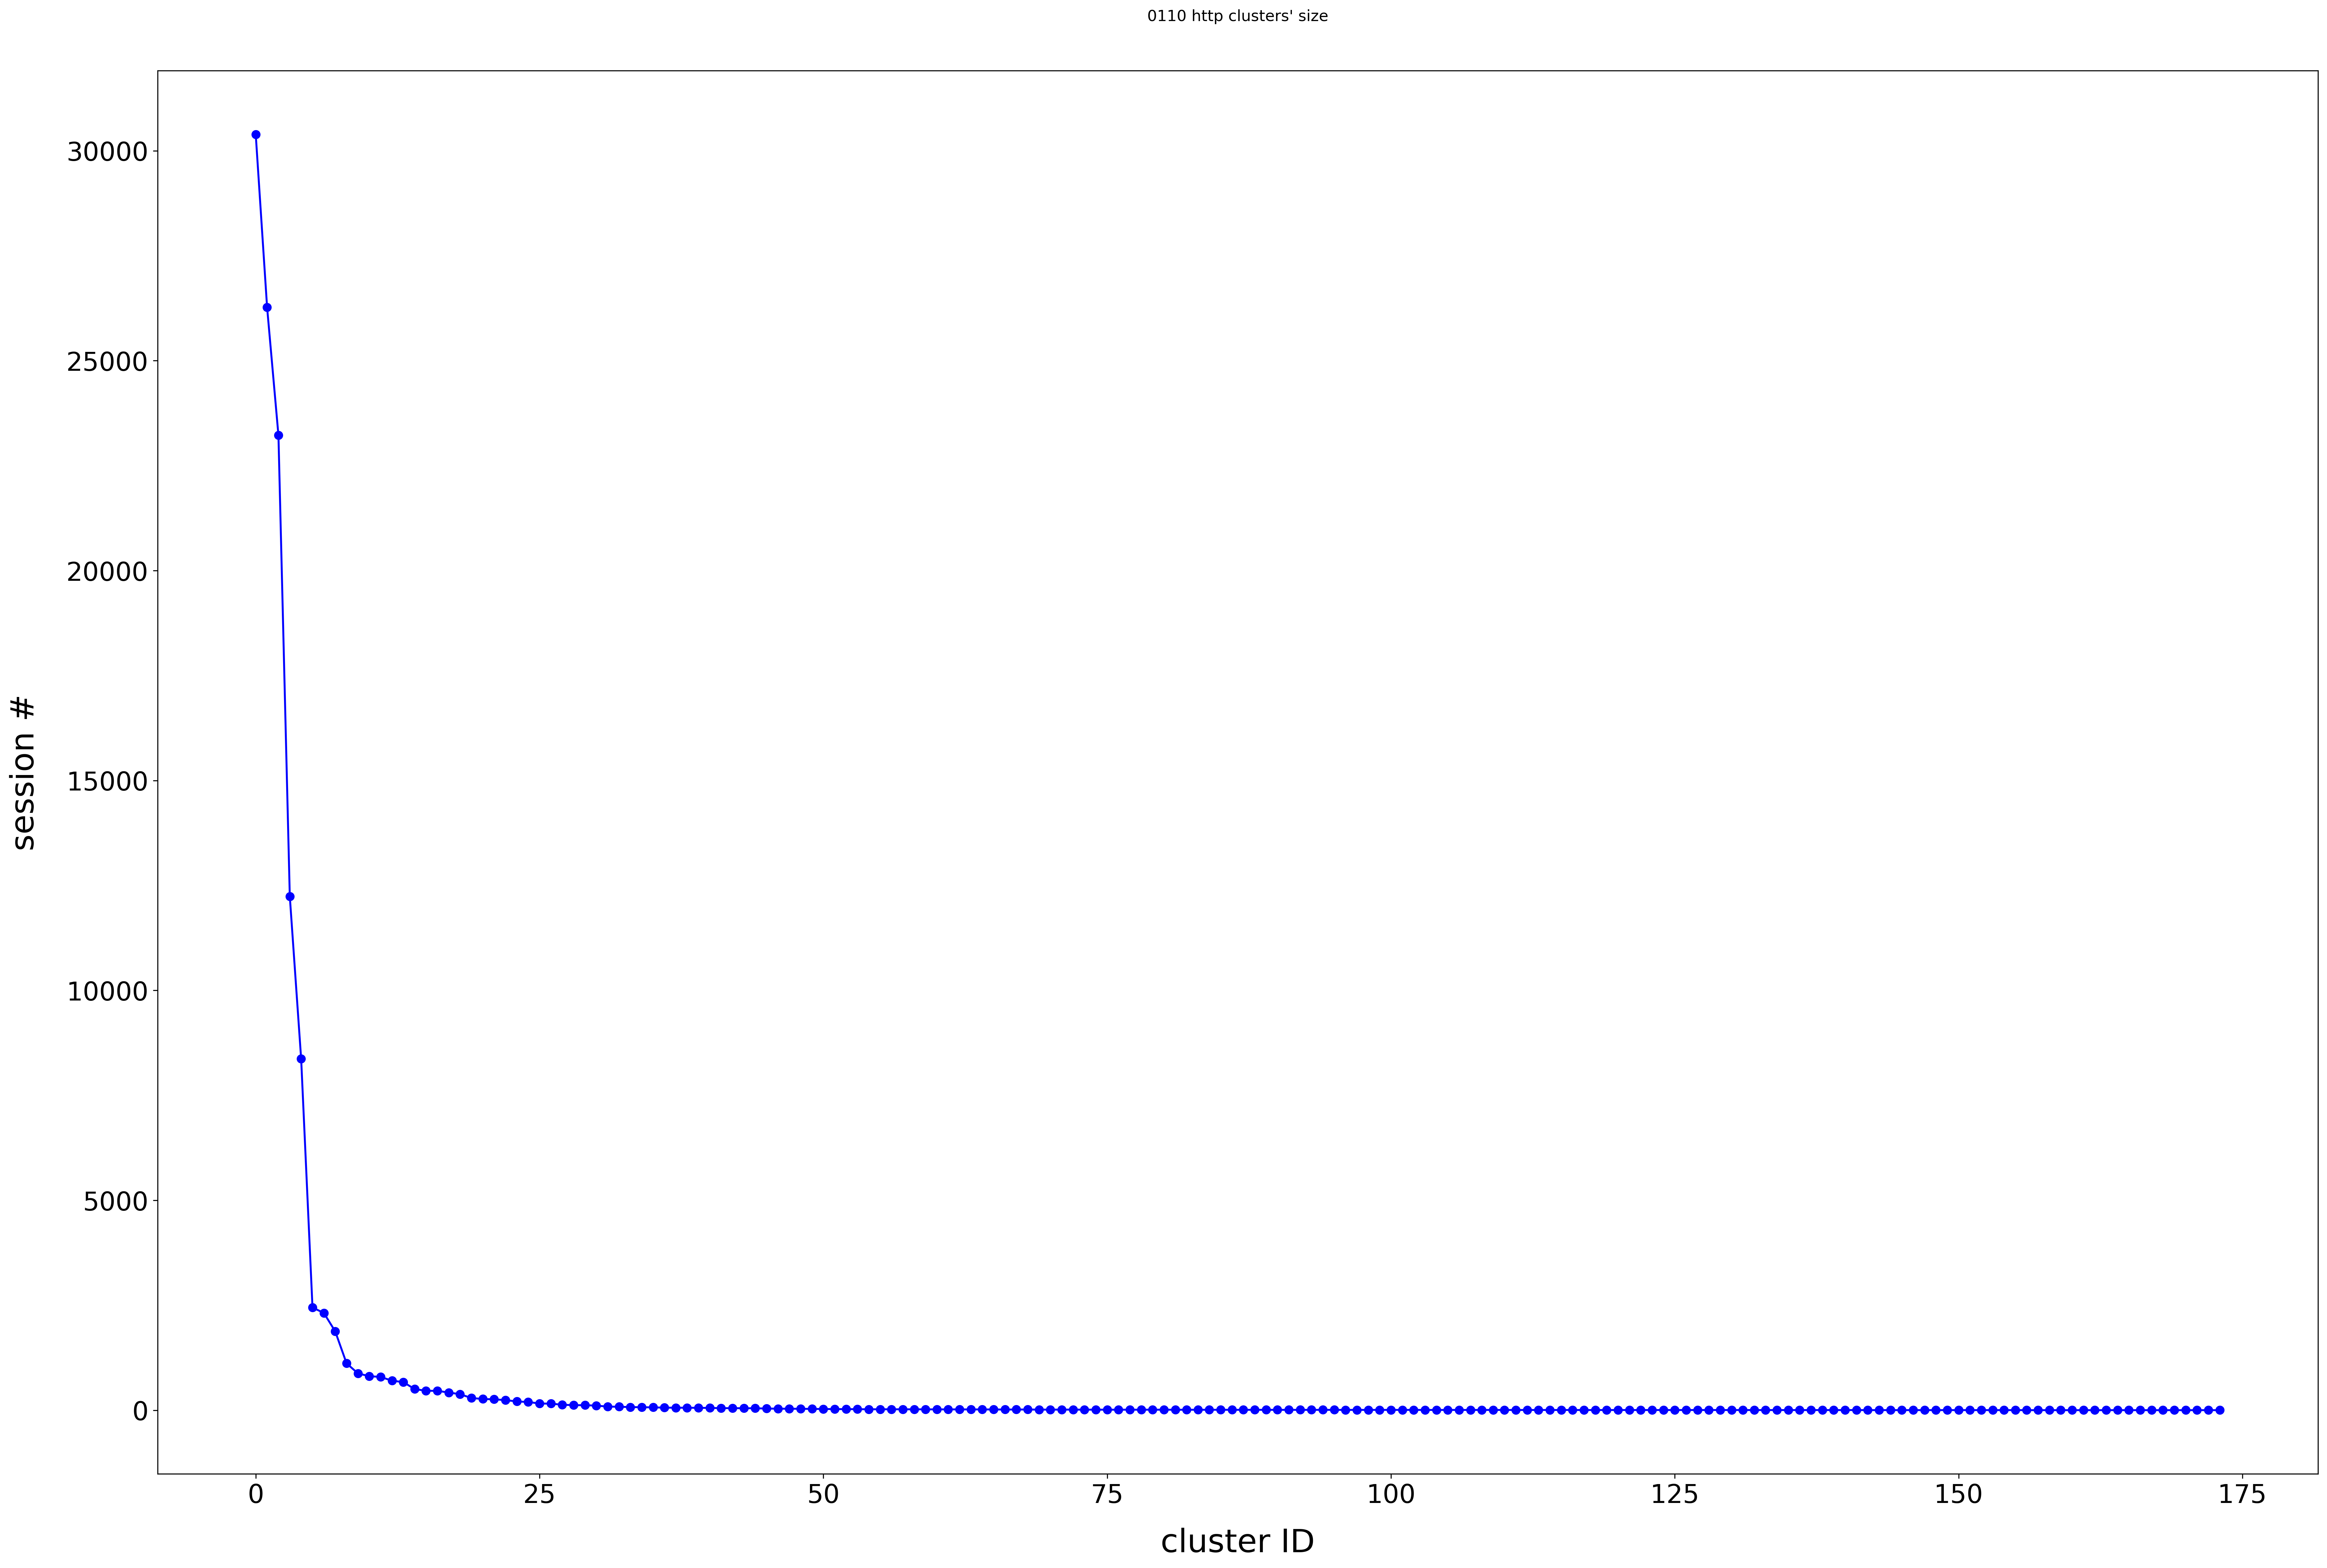

1

In [399]:
http_dict_len = {}
for k,v in http_big_dict.items():
    http_dict_len[k] = len(v)+1
temp = list(http_dict_len.values())
for i in range(18):
    temp.append(1)
temp = sorted(temp,reverse=True)
temp_df = knee_point(temp)
temp_df.index[0]-1

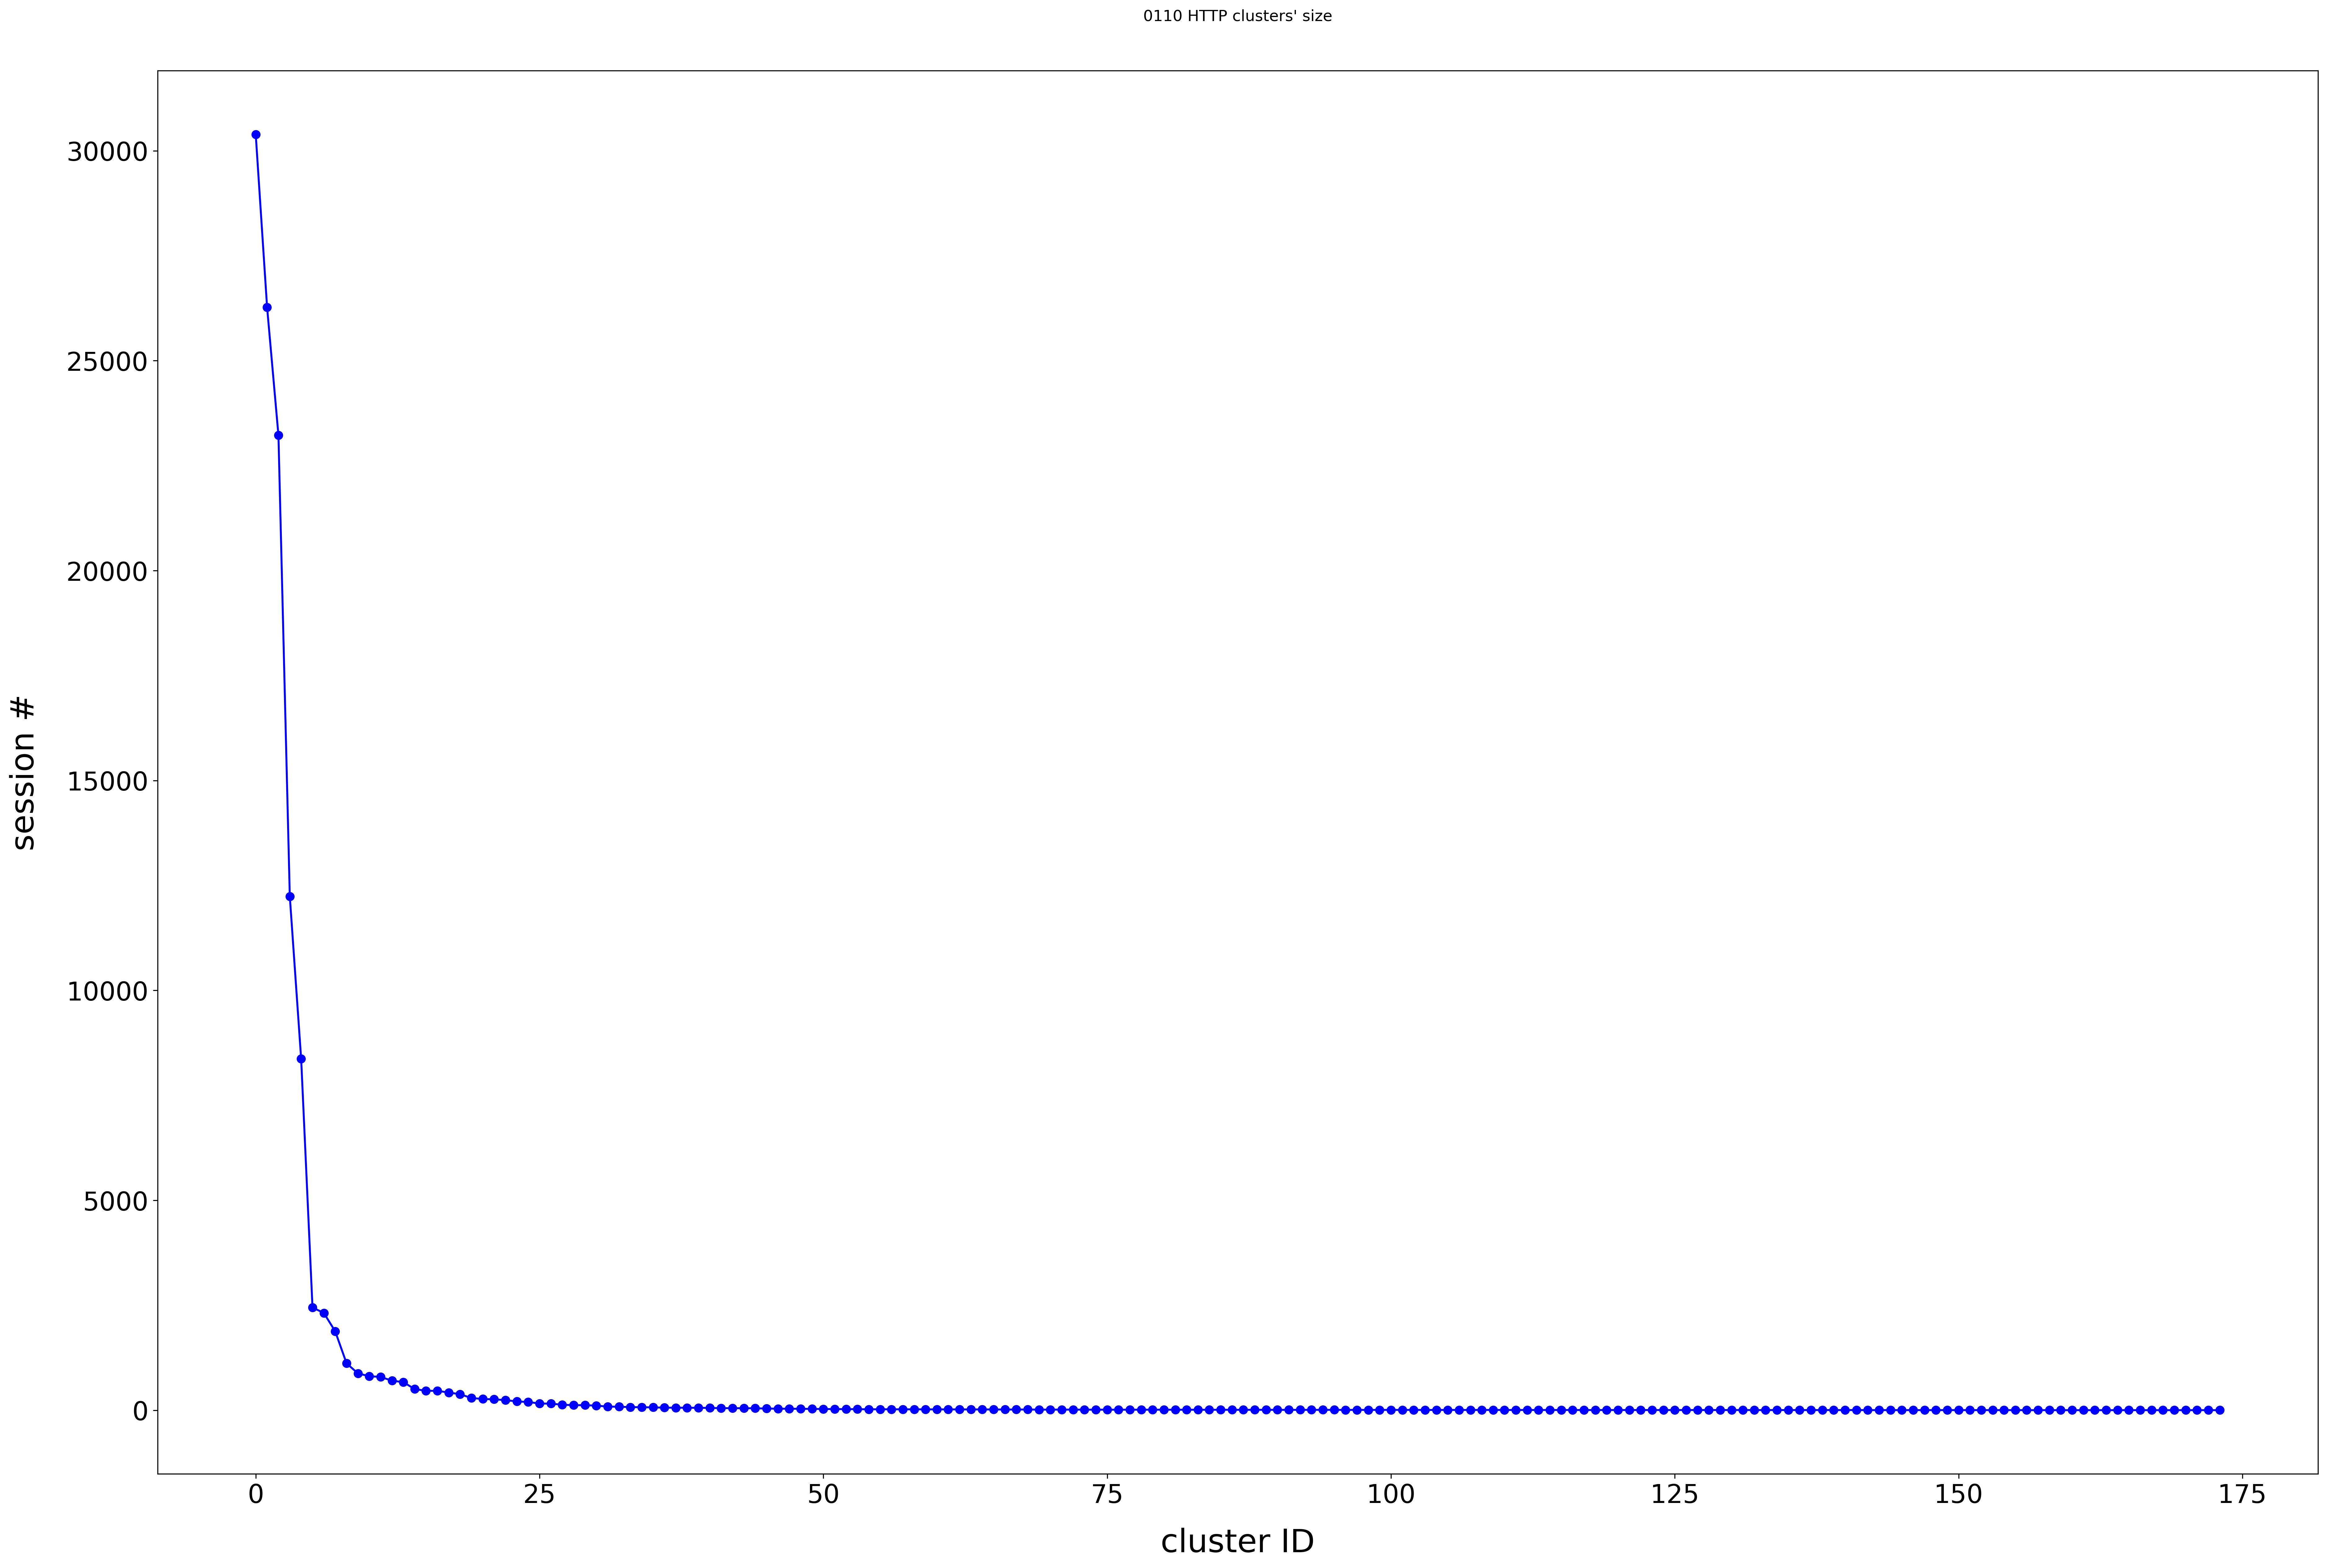

In [388]:
x_axis = [x for x in range(len(temp))]
plt.figure(figsize=(30,20),dpi=300,linewidth = 1)
plt.plot(x_axis,temp,'o-',color = 'b', label="http")
plt.title("0110 HTTP clusters' size", x=0.5, y=1.03)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("cluster ID", fontsize=25, labelpad = 15)
plt.ylabel("session #", fontsize=25, labelpad = 20)
# plt.ylim(0, 2500)
# plt.legend(loc = "best", fontsize=20)
plt.show()

http

In [300]:
http_df, http_df_payload = prepare_df(df2,'http')
http_big_dict,http_loners,http_score,http_cluster_score_dict = similarity_compare(http_df,http_df_payload,thr=0)
gc.collect() #05:38

/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

0

In [311]:
http_cluster_score_dict[92]

[20.0,
 47.0,
 47.0,
 47.0,
 55.0,
 55.0,
 55.0,
 55.0,
 55.0,
 66.0,
 54.0,
 47.0,
 47.0,
 55.0,
 55.0,
 55.0,
 55.0,
 55.0,
 55.0,
 49.0,
 36.0,
 38.0,
 44.0,
 44.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 44.0,
 54.0,
 47.0,
 60.0,
 60.0,
 60.0,
 60.0,
 60.0,
 60.0,
 60.0,
 50.0,
 46.0,
 29.0,
 29.0,
 29.0,
 29.0,
 52.0,
 50.0,
 44.0,
 44.0,
 44.0,
 35.0,
 46.0,
 46.0,
 55.0,
 54.0,
 49.0,
 52.0,
 47.0,
 47.0,
 47.0,
 47.0,
 30.0,
 33.0,
 32.0,
 25.0,
 32.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 36.0,
 54.0,
 47.0,
 44.0,
 65.0,
 66.0,
 61.0,
 50.0,
 50.0,
 44.0,
 47.0,
 50.0,
 68.0,
 38.0,
 38.0,
 50.0,
 49.0,
 49.0,
 49.0,
 49.0,
 49.0,
 49.0,
 19.0,
 49.0,
 49.0,
 49.0,
 47.0,
 47.0,
 49.0,
 49.0,
 49.0,
 40.0,
 41.0,
 40.0,
 41.0,
 38.0,
 36.0,
 36.0,
 36.0,
 52.0,
 36.0,
 36.0,
 36.0,
 38.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 38.0,
 36.0,
 35.0,
 36.0,
 36.0,
 36.0,
 35.0,
 36.0,
 36.0,
 36.0,
 49.0,
 49.0,
 49.0,
 49.0,
 49.0,
 54.0,
 52.0,
 54.0,
 46.0,

原本總共sessions#: 118565
共有#sessions可分群: 118547 共有#lonerSessions: 18
可分為#群: 156
前三大的cluster key與對應之群集大小
 124     30388
1828    26274
92      23222
3228    12241
3665     8371
Name: 0, dtype: int64
                  0
count    156.000000
mean     759.916667
std     3855.043498
min        2.000000
25%        4.750000
50%       12.000000
75%       56.750000
max    30388.000000


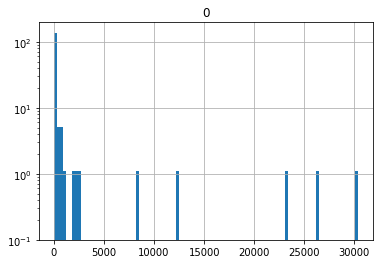

In [309]:

cluster_stat(http_big_dict,http_df,drawlog=True)

                  0
count  1.332182e+06
mean   5.853760e+00
std    1.843197e+01
min    0.000000e+00
25%    0.000000e+00
50%    0.000000e+00
75%    0.000000e+00
max    1.000000e+02


{100.0: 7137,
 99.0: 707,
 97.0: 1074,
 96.0: 1198,
 94.0: 2834,
 93.0: 1388,
 91.0: 3196,
 90.0: 742,
 88.0: 2292,
 86.0: 295,
 85.0: 661,
 84.5: 4,
 83.0: 385,
 82.0: 544,
 80.5: 2,
 80.0: 674,
 79.0: 599,
 77.0: 535,
 76.5: 1,
 76.0: 1,
 75.5: 1,
 75.0: 1052,
 74.0: 1522,
 73.5: 1,
 73.0: 2,
 72.5: 1,
 72.0: 1365,
 71.5: 1,
 71.0: 1633,
 70.5: 2,
 70.0: 2,
 69.0: 2461,
 68.0: 1875,
 66.0: 3241,
 65.0: 2819,
 64.0: 15,
 63.0: 3647,
 62.0: 11,
 61.0: 2259,
 60.0: 2724,
 58.0: 3991,
 57.0: 7248,
 56.0: 2,
 55.0: 6942,
 54.0: 7836,
 52.0: 3442,
 50.0: 7021,
 49.0: 8019,
 48.5: 1,
 48.0: 54,
 47.0: 5370,
 46.5: 1,
 46.0: 3665,
 44.75: 1,
 44.0: 2002,
 43.0: 561,
 42.0: 407,
 41.5: 1,
 41.0: 1300,
 40.0: 2799,
 39.5: 1,
 38.0: 2966,
 37.0: 6,
 36.0: 3928,
 35.0: 1306,
 34.0: 86,
 33.0: 668,
 32.75: 1,
 32.5: 1,
 32.0: 622,
 31.333333333333332: 1,
 30.0: 571,
 29.5: 1,
 29.0: 860,
 28.75: 1,
 28.5: 1,
 28.0: 6,
 27.75: 1,
 27.0: 96,
 26.75: 1,
 26.0: 5,
 25.75: 1,
 25.0: 82,
 24.75: 1,
 24

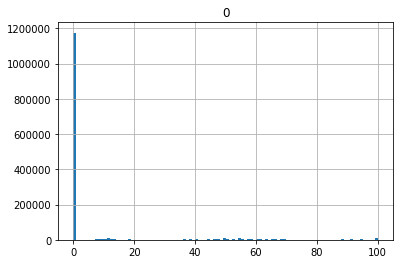

In [310]:
temp = pd.DataFrame(http_score)
temp.hist(bins=100)
print(temp.describe())
temp = dict(Counter(http_score))
{k: v for k, v in sorted(temp.items(), key=lambda item: item[0],reverse=True)}

In [315]:
http_loner_df = df2.loc[http_loners]
pickle.dump(obj=http_loner_df,file=open(pickle_dir+'0110_http_loner_df.pkl','wb'))
http_loner_df

,session_time,session_time_list,session_duration,session_tt_packet,session_i_tt_packet,session_o_tt_packet,session_tt_frame_length,session_i_tt_frame_length,session_o_tt_frame_length,udp_tt_length,udp_i_tt_length,udp_o_tt_length,udp_i_avg_length,udp_o_avg_length,icmp_i_avg_length,icmp_o_avg_length,icmp_tt_original_datagram_length,icmp_i_tt_datagram_length,icmp_o_tt_datagram_length,icmp_i_avg_datagram_length,icmp_o_avg_datagram_length,tcp_tt_payload_length,tcp_i_tt_payload_length,tcp_o_tt_payload_length,tcp_i_avg_payload_length,tcp_o_avg_payload_length,ip_src,ip_dst,tcp_srcport,tcp_dstport,udp_srcport,udp_dstport,country,city,subdivisions,domain,isp,frame_i_common_protocols,frame_o_common_protocols,frame_i_max_protocols,frame_o_max_protocols,tcp_i_payload_list,tcp_o_payload_list
3366603,1.578642e+09,"[1578641803.689616, 1578641803.689806, 1578641...",5.519835,822,483,339,1621558,26422.0,1595136.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1577128.0,328.0,1576800.0,0.679089,4651.327434,203.150.154.191,210.242.149.157,46444.0,80.0,NaN,NaN,Thailand,Chiang Mai,Chiang Mai,inet.co.th,Internet Thailand Company Limited,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http,eth:ethertype:ip:tcp:http:data-text-lines,[[24:Da7MgD3Wlt8FYp4o032B9ih032B9iU6ZYle:Da7nW...,[[96:bqb46gCp4QuQxr9hEjqozJnsnSnrnb0MyAPJVHbOL...
6832388,1.578617e+09,"[1578617320.535536, 1578617320.53576, 15786173...",6.380678,11,6,5,1161,821.0,340.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,443.0,441.0,2.0,73.500000,0.400000,149.129.50.37,210.242.149.53,45532.0,8080.0,NaN,NaN,China,None,None,None,Alibaba,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http,eth:ethertype:ip:tcp:http:data,[[24:3/6tMAaw9cOTH3cx9cOFUvcHTbzJJ0Zs2CsLN/65I...,"[[3:Sn:Sn, 1578617326.863735000, 2]]"
7984647,1.578596e+09,"[1578596040.180659, 1578596040.181096, 1578596...",31.179855,832,459,373,1123967,33613.0,1090354.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1066779.0,1051.0,1065728.0,2.289760,2857.179625,5.188.211.35,210.242.148.151,56653.0,80.0,NaN,NaN,Russia,None,None,None,Petersburg Internet Network ltd.,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http:urlencoded-form,eth:ethertype:ip:tcp:http:data-text-lines,[[96:RCx1uw1Cf9fzyY1kOQQ4gUOW1c5eu5zWZ:RCEf9fz...,[[96:1b4l1Cp4QuQxr9pHjqozJnsnSnrnb0Kdr/D18:pi8...
10873635,1.578628e+09,"[1578627974.136787, 1578627974.137149, 1578627...",40.537868,70,45,25,105835,16843.0,88992.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101833.0,14233.0,87600.0,316.288889,3504.000000,172.80.253.50,210.242.148.179,36006.0,80.0,NaN,NaN,Iran,None,None,None,Mobile Communication Company of Iran PLC,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http:urlencoded-form,eth:ethertype:ip:tcp:http:data-text-lines,[[96:R/i1uw1CFBY1kXtJs3m5znXFm50m5/P6QVnXN69f6...,[[96:bjb4ZCp4QuQxr9LjqozJnsnSnrnb0sHtUd+xRE3c:...
11519214,1.578598e+09,"[1578597921.149954, 1578597921.150251, 1578597...",21.646746,780,425,355,1095338,30788.0,1064550.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1042162.0,1050.0,1041112.0,2.470588,2932.709859,5.188.211.35,210.242.145.157,46391.0,80.0,NaN,NaN,Russia,None,None,None,Petersburg Internet Network ltd.,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http:urlencoded-form,eth:ethertype:ip:tcp:http:data-text-lines,[[96:RNx1uw1CWCzY1kxIICmEFh95xelchRIE9:RNEWCjx...,[[96:qyb44Cp4QuQxr9ejqozJnsnSnrnb0xAsiSQo8ko:q...
18250590,1.578628e+09,"[1578628372.93373, 1578628372.933942, 15786283...",31.924667,32,16,16,52151,15351.0,36800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50351.0,14471.0,35880.0,904.437500,2242.500000,200.255.122.170,210.242.145.150,4965.0,80.0,NaN,NaN,Brazil,Rio de Janeiro,Rio de Janeiro,embratel.com.br,Claro S.A.,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http:data,eth:ethertype:ip:tcp:http:data-text-lines,[[48:R1Aa4tP/nY18n/0Oy218hw18JPrBXxc29nXflrBXx...,[[96:b9b4+2Cp4QuQxr9NjqozJnsnSnrnb0QYGyftbRK:b...
20099388,1.

In [ ]:
http_big_dict = case_cluster_info(http_loners,http_big_dict,http_df,proto='http') #write to pkl

In [68]:
# loner_0 = df2.loc[http_loners].session_time_list.tolist()
# loner_0 = [list(x)for x in loner_0]
# pickle.dump(obj=loner_0,file=open(pickle_dir+'http_0_loners.pkl','wb'))

In [77]:

# write2pkl(http_df,http_big_dict,124,"http_1")
# write2pkl(http_df,http_big_dict,1828,"http_2")
# write2pkl(http_df,http_big_dict,92,"http_3")
# write2pkl(http_df,http_big_dict,3228,"http_4")
# write2pkl(http_df,http_big_dict,3665,"http_5")

Unique Country#: 99 Unique IP#: 2249 Session#: 30394
Unique Country#: 61 Unique IP#: 559 Session#: 26274
Unique Country#: 135 Unique IP#: 7891 Session#: 23222
Unique Country#: 21 Unique IP#: 58 Session#: 12241
Unique Country#: 22 Unique IP#: 62 Session#: 8371


{'icoord': [[1415.0, 1415.0, 1425.0, 1425.0],
  [1405.0, 1405.0, 1420.0, 1420.0],
  [1395.0, 1395.0, 1412.5, 1412.5],
  [1385.0, 1385.0, 1403.75, 1403.75],
  [1375.0, 1375.0, 1394.375, 1394.375],
  [1365.0, 1365.0, 1384.6875, 1384.6875],
  [1355.0, 1355.0, 1374.84375, 1374.84375],
  [1345.0, 1345.0, 1364.921875, 1364.921875],
  [1335.0, 1335.0, 1354.9609375, 1354.9609375],
  [1325.0, 1325.0, 1344.98046875, 1344.98046875],
  [1315.0, 1315.0, 1334.990234375, 1334.990234375],
  [1305.0, 1305.0, 1324.9951171875, 1324.9951171875],
  [1295.0, 1295.0, 1314.99755859375, 1314.99755859375],
  [1285.0, 1285.0, 1304.998779296875, 1304.998779296875],
  [1275.0, 1275.0, 1294.9993896484375, 1294.9993896484375],
  [1265.0, 1265.0, 1284.9996948242188, 1284.9996948242188],
  [1255.0, 1255.0, 1274.9998474121094, 1274.9998474121094],
  [1245.0, 1245.0, 1264.9999237060547, 1264.9999237060547],
  [1235.0, 1235.0, 1254.9999618530273, 1254.9999618530273],
  [1225.0, 1225.0, 1244.9999809265137, 1244.9999809265

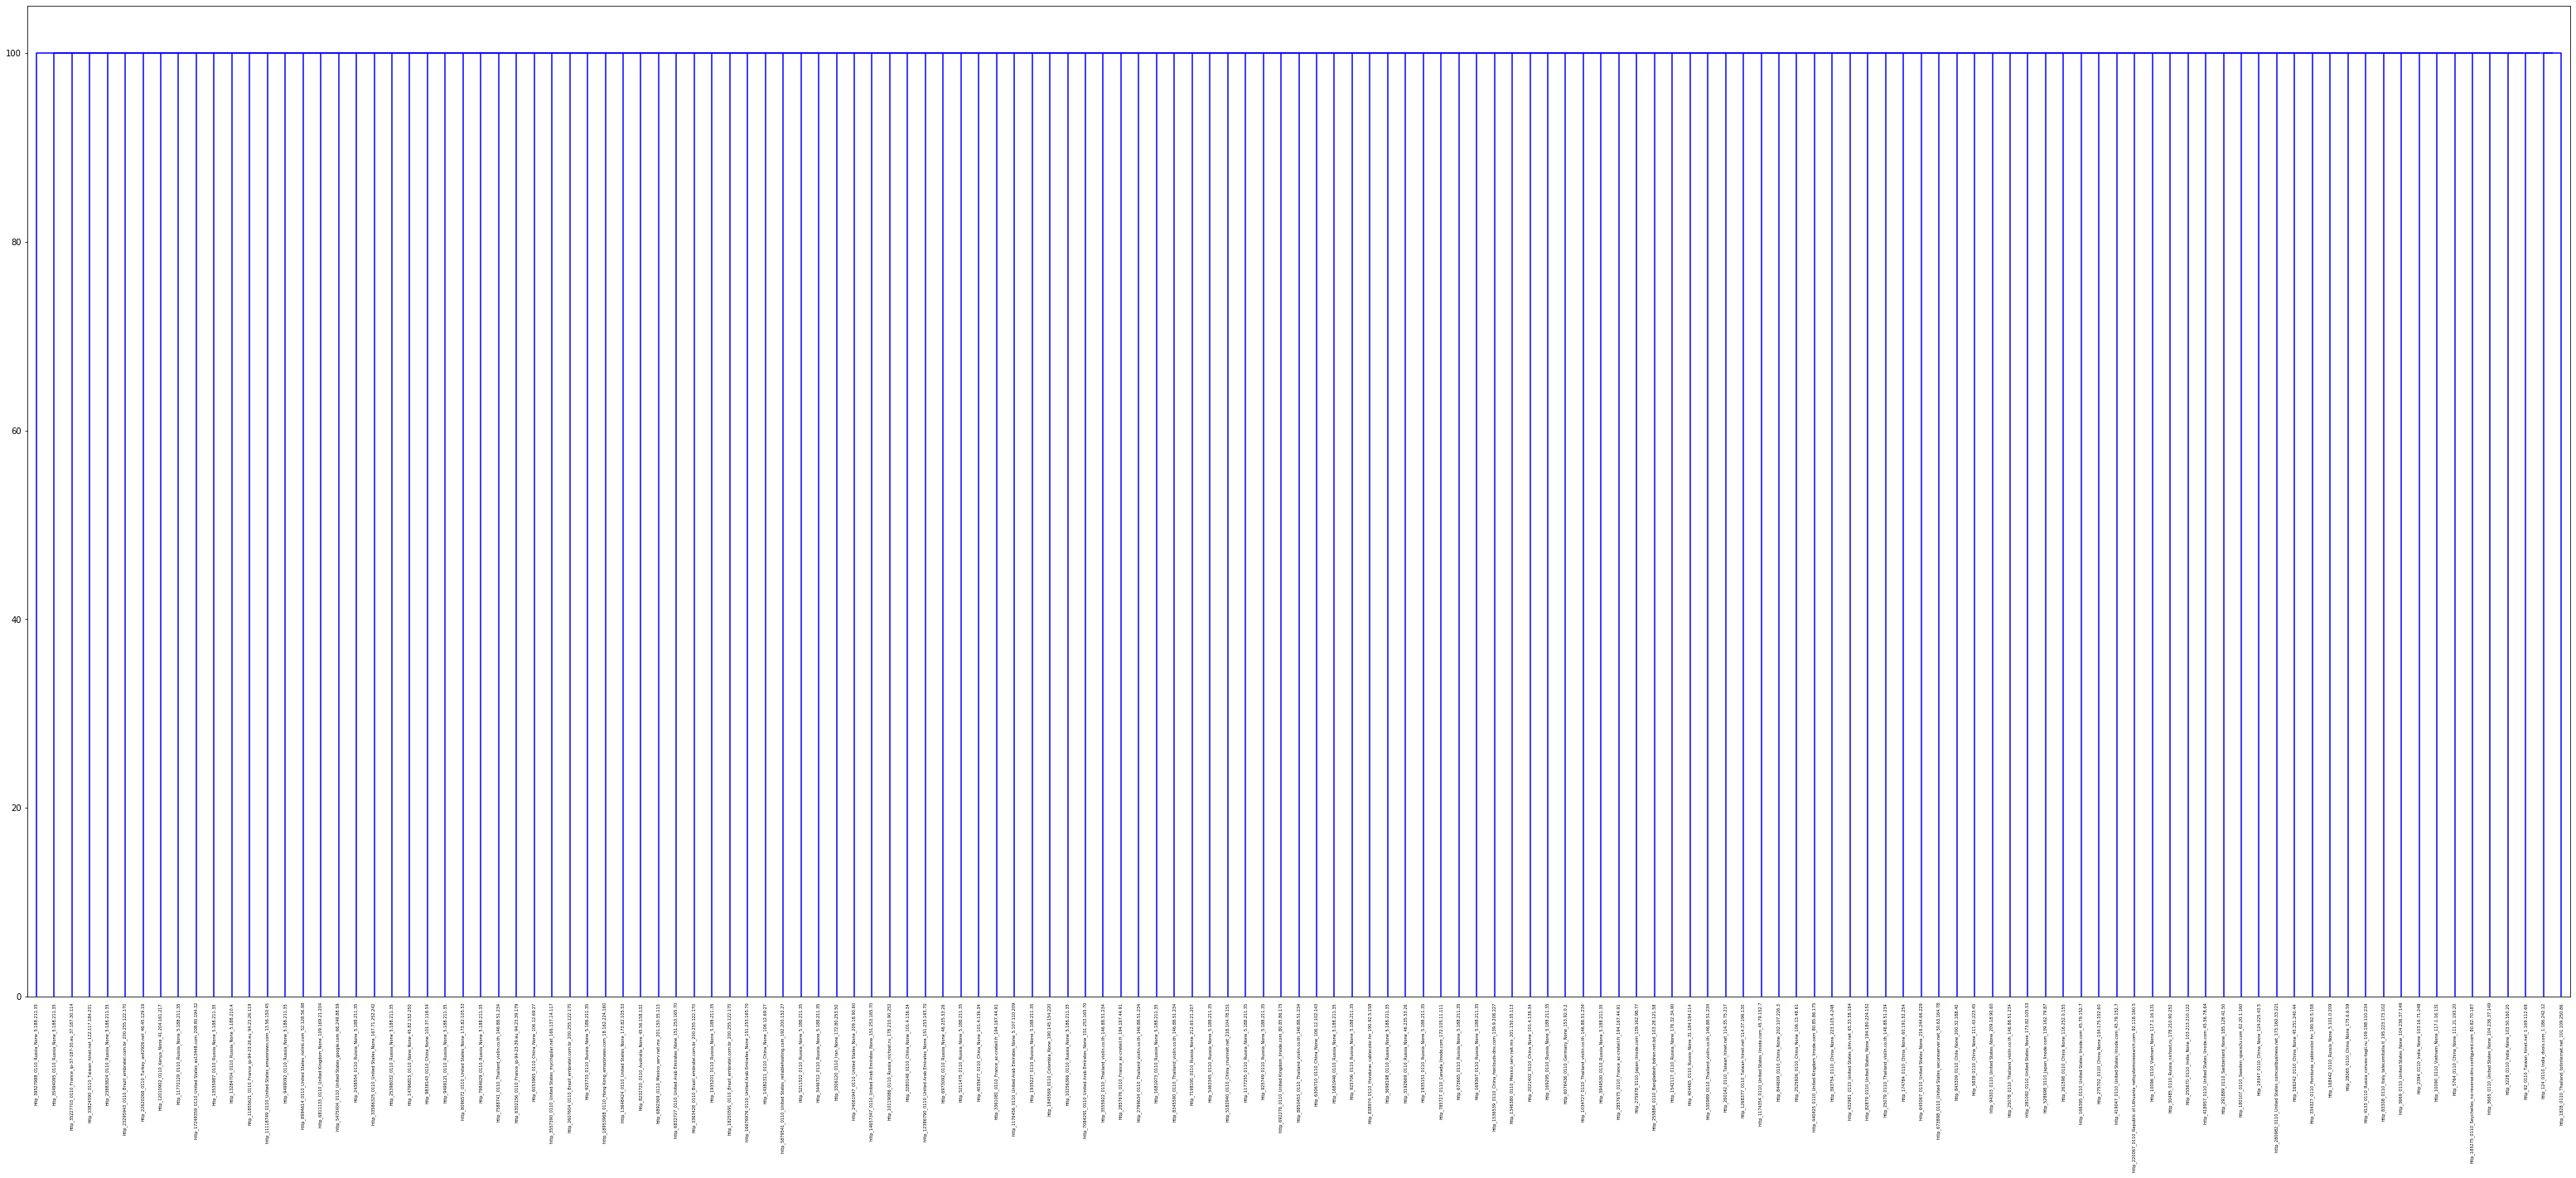

In [283]:
http_upgma_dict = cluster_rep_hash(http_big_dict,http_df_payload,http_df,date='0110',protocol='http')
pickle.dump(obj=http_upgma_dict,file=open(pickle_dir+'http_upgma_dict_0110.pkl','wb'))
http_upgma_df = pair_wise_score(http_upgma_dict)
draw_upgma(http_upgma_df,name='0110_upgma')

合併三個dict用update來合併以後再通過後面的df function畫圖

In [46]:
# 大家的pickle_dir都不同0109 0110 0111
# time1 = '10'
# time2 = '02'
# time3 = '30'
time_li = ['06','07','08','09','10','11','12']
# time_li = ['02','10','30']
proto = 'http'
three_dict = {}
for time in time_li:
    path = '/home/antslab/spark_data/pcap_inter/2020_01_'+str(time)+'/中華電信/case_pickles/'+proto+'_upgma_dict_01'+str(time)+'.pkl'
    temp = pickle.load(open(path,'rb'))
    three_dict.update(temp)

    
loner_dict = {}
for k,v in three_dict.items():
    if '_L_' in k:
        loner_dict[k]=v
    if '_S_' in k:
        loner_dict[k] =v

loner_dict

{'http_L_146028893452_0106_Colombia_cable.net.co_186.84.90.154': '24:tAQcXoa7MgWRYNbExMzNfjeZt1HqafCqf+Mg0AUC/:+QVa7dbMMzsyq2LP',
 'http_L_412316876852_0106_France_ip-94-23-31.eu_94.23.31.18': '24:Da7M7l/IDafCqYCii6DPvqGj731Y27GEfLXvpmGb2:Da7zqR6WGjJL7GEDxmGb2',
 'http_L_455266533925_0106_China_None_106.12.69.27': '48:3ZW8aKu185yqiY18R475SrZWT1+e5VjhjjhX3R:bu1VY1K4dSRePljlx',
 'http_L_463856474332_0106_Thailand_inet.co.th_203.150.179.232': '24:Da7M7BeQqlt8FYp4o032B97C032B9Yl+K6ZYle:Da7+DqltbVJBtCJBSsTf',
 'http_L_472446419800_0106_China_None_114.230.69.165': '96:neoPmPbunXNmebImqbHPU22KXnXNU221FPU22TqPUrUnXNUY6UYN3UYAxnXFUYA2:pPmP6ndme0mqbPU22KXndU221dU22Tqx',
 'http_L_532575964415_0106_Japan_linode.com_139.162.98.77': '96:RgpvMpV1uw1CF7Y1kLBP8AnXN8D863FyZNnXFF/ZPFFZI3U/SCCnXFUx:RgpvMpYFrLBP8And8D863FynnVF/FFFz',
 'http_L_549755844489_0106_United States_googleusercontent.com_34.77.67.249': '96:RMY1kc/Os1uw11N4Gg3IunXFI/3IkPUg4O4WnXNUg4R4gUg4t4v3HpnXFKV3U8z:R+c/OE4d3IunVI/IkPUg4O4WndUg4

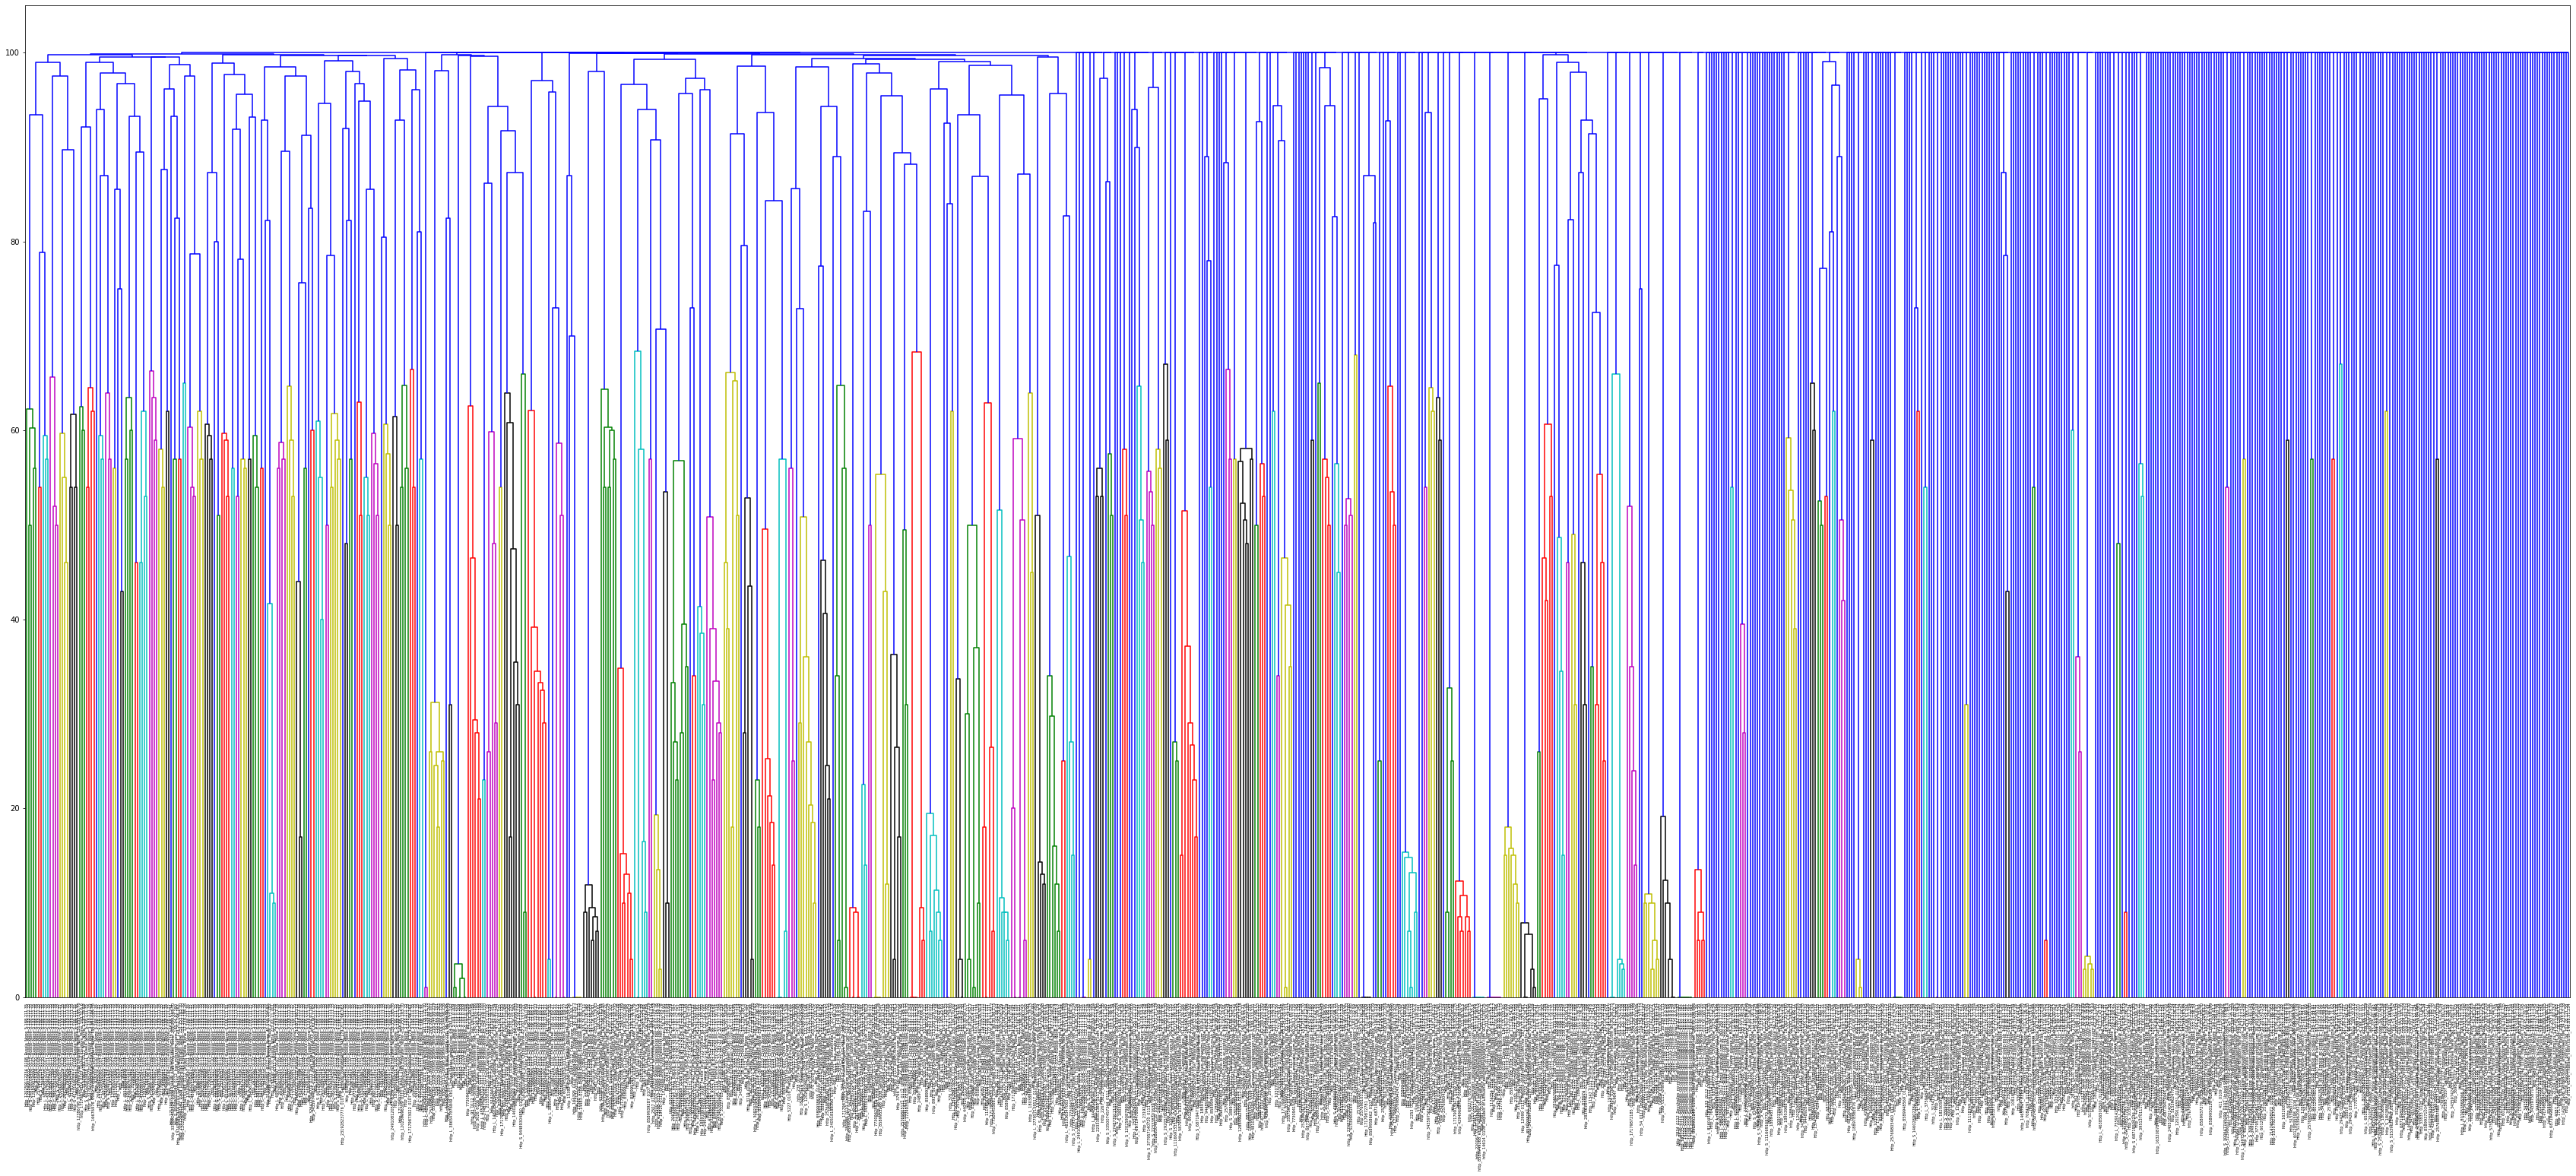

In [47]:
three_upgma_df = pair_wise_score(three_dict) #改!!
dn,Z = draw_upgma(three_upgma_df,
           picture_dir='/home/antslab/spark_data/pcap_inter/2020_01_06/中華電信/case_pictures/' #改!!
           ,name='0106-0112_upgma') #改!! 0106-0112_upgma

In [50]:
Z

array([[3.000e+00, 5.760e+02, 0.000e+00, 2.000e+00],
       [6.350e+02, 8.110e+02, 0.000e+00, 2.000e+00],
       [8.000e+00, 1.360e+02, 0.000e+00, 2.000e+00],
       ...,
       [1.732e+03, 2.103e+03, 1.000e+02, 8.870e+02],
       [1.122e+03, 2.104e+03, 1.000e+02, 8.890e+02],
       [1.727e+03, 2.105e+03, 1.000e+02, 1.054e+03]])

## 畫跨天protocol大小圖

In [143]:
trend_dict_time_all = {}
trend_dict_country_all = {}
trend_dict_ip_all = {}
trend_dict_ssdeep_all = {}
def draw_trend_pic(date,proto,pickle_dir,trend_dict_time_all=trend_dict_time_all,trend_dict_country_all=trend_dict_country_all,trend_dict_ip_all=trend_dict_ip_all,trend_dict_ssdeep_all=trend_dict_ssdeep_all):
    '''
    GOAL: output dict to draw trend-circle picture
    
    Return: 4 dict for the same proto for the next day
    '''
    try:
        (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
                                proto_upgma_dict,stat_df) = pickle.load(open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','rb'))
    except ValueError:
        (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
                                proto_upgma_dict) = pickle.load(open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','rb'))
    except FileNotFoundError:
        return trend_dict_time_all,trend_dict_country_all,trend_dict_ip_all,trend_dict_ssdeep_all


    def ssdeep_compare(target_hash,candidate_df):
        '''
        Input1: string of hash
        Input2: dataframe of candidate
        '''
        def compare(candidate_hash):
            if type(candidate_hash) == str:
                return ssdeep.compare(target_hash,candidate_hash)
            else:
                score_li = []
                for c_h in candidate_hash:
                    score_li.append(ssdeep.compare(target_hash,c_h))
                return max(score_li)
        return candidate_df.hash.map(compare)

    trend_dict_time = {}
    trend_dict_country = {}
    trend_dict_ip = {}
    trend_dict_ssdeep = {}
    candidate_df = pd.DataFrame(trend_dict_ssdeep_all.items(),columns=['idx','hash']) #其他已經有的cluster
    for key,value in proto_big_dict.items():
        target = proto_df_payload[proto_df_payload.idx == key]
        target = target.reset_index(drop=True)
        t_len = len(target)
        q2 = int(t_len*0.5)
        t_q2 = target.iloc[q2,-1] #要跟別人比較的cluster hash
        if trend_dict_ssdeep_all == {}: #第一次
            trend_dict_ssdeep[str(date)+"_"+str(key)] = t_q2
            member_li = value[:]
            member_li.append(key)
            select_df = proto_df.loc[member_li]
            time_li = select_df.session_time.tolist()
            trend_dict_time[str(date)+"_"+str(key)] = time_li
            country_li = select_df.country.tolist()
            ip_li = select_df.ip_src.tolist()
            assert len(time_li) == len(country_li) == len(ip_li)
            trend_dict_country[str(date)+"_"+str(key)] = country_li
            trend_dict_ip[str(date)+"_"+str(key)] = ip_li
        else: #後面幾次
            candidate_df['score'] = ssdeep_compare(t_q2,candidate_df) 
            max_score = candidate_df.score.max()
            if max_score < 1: #都沒有相近的
                trend_dict_ssdeep[str(date)+"_"+str(key)] = t_q2
                member_li = value[:]
                member_li.append(key)
                select_df = proto_df.loc[member_li]
                time_li = select_df.session_time.tolist()
                trend_dict_time[str(date)+"_"+str(key)] = time_li
                country_li = select_df.country.tolist()
                ip_li = select_df.ip_src.tolist()
                assert len(time_li) == len(country_li) == len(ip_li)
                trend_dict_country[str(date)+"_"+str(key)] = country_li
                trend_dict_ip[str(date)+"_"+str(key)] = ip_li
            elif max_score>0: #有相近的合併到原本的dict
                try:
                    combine_id = candidate_df[candidate_df.score == max_score].idx.tolist()[0]
                except:
                    print( candidate_df,max_score,target)
                ori_ssdeep_list = trend_dict_ssdeep_all[combine_id][:]
                if type(ori_ssdeep_list) == str:
                    ori_ssdeep_list = [ori_ssdeep_list] #之前只有一個ssdeep hash
                ori_time_list = trend_dict_time_all[combine_id][:]
                ori_country_list = trend_dict_country_all[combine_id][:]
                ori_ip_list = trend_dict_ip_all[combine_id][:]
                member_li = value[:]
                member_li.append(key)
                select_df = proto_df.loc[member_li]
                time_li = select_df.session_time.tolist()
                ori_time_list.extend(time_li)
                country_li = select_df.country.tolist()
                ip_li = select_df.ip_src.tolist()
                ori_country_list.extend(country_li)
                ori_ip_list.extend(ip_li)
                ori_ssdeep_list.append(t_q2) #我合併進入別人的群，所以把我群的key hash也加入
                assert len(ori_time_list) == len(ori_country_list) == len(ori_ip_list)
                trend_dict_time_all[combine_id] = ori_time_list
                trend_dict_country_all[combine_id] = ori_country_list
                trend_dict_ip_all[combine_id] = ori_ip_list
                trend_dict_ssdeep_all[combine_id] = ori_ssdeep_list
            else:
                print(max_score)
#         break #debug
    trend_dict_time_all.update(trend_dict_time)
    trend_dict_country_all.update(trend_dict_country)
    trend_dict_ip_all.update(trend_dict_ip)
    trend_dict_ssdeep_all.update(trend_dict_ssdeep)
    return trend_dict_time_all,trend_dict_country_all,trend_dict_ip_all,trend_dict_ssdeep_all

In [142]:
def sort_li(time_li, country_li):
    '''
    GOAL: sort by time (align with time's order)
    Return: list
    '''
    sort_country_li = [x for _,x in sorted(zip(time_li,country_li))]
    return sort_country_li

In [144]:

# date_li = ["0110","0130","0102"]
date_li = ["0102","0106","0107","0108","0109","0110","0111","0112","0130"] #,"0102","0130"
proto_li = ['http','smb','telnet','ftp','smtp','mysql','ssh','rpc','imap','pop','sip']
for proto in tqdm(proto_li):
    trend_dict_time_all = {}
    trend_dict_country_all = {}
    trend_dict_ip_all = {}
    trend_dict_ssdeep_all = {}
    for date in date_li:
        pickle_dir = '/home/antslab/spark_data/pcap_inter/2020_01_'+str(date[-2:])+'/中華電信/case_pickles/'
        trend_dict_time_all,trend_dict_country_all,trend_dict_ip_all,trend_dict_ssdeep_all = draw_trend_pic(date,proto,
                                                                                          pickle_dir,trend_dict_time_all,trend_dict_country_all,trend_dict_ip_all,trend_dict_ssdeep_all)
    trend_dict_time_all = {k: v for k, v in sorted(trend_dict_time_all.items(), key=lambda item: len(item[1]),reverse=True)}
    time_df = pd.DataFrame(trend_dict_time_all.items(),columns=['idx','timestamp'])
    trend_dict_country_all = {k: v for k, v in sorted(trend_dict_country_all.items(), key=lambda item: len(item[1]),reverse=True)}
    country_df = pd.DataFrame(trend_dict_country_all.items(),columns=['idx','country'])
    trend_dict_ip_all = {k: v for k, v in sorted(trend_dict_ip_all.items(), key=lambda item: len(item[1]),reverse=True)}
    ip_df =  pd.DataFrame(trend_dict_ip_all.items(),columns=['idx','src_ip'])
    ssdeep_df = pd.DataFrame(trend_dict_ssdeep_all.items(),columns=['idx','ssdeep'])
    all_df = pd.merge(time_df,country_df,on='idx')
    all_df =  pd.merge(all_df,ip_df,on='idx')
    all_df = pd.merge(all_df,ssdeep_df,on='idx')
    all_df['country'] = all_df.apply(lambda x: sort_li(x.timestamp, x.country), axis=1)
    all_df['src_ip'] = all_df.apply(lambda x: sort_li(x.timestamp, x.src_ip), axis=1)
    all_df['timestamp'] = all_df.timestamp.map(sorted)
    file_name = "_".join(sorted(date_li))
    pickle.dump(obj=all_df,
                file=open('/home/antslab/spark_data/pcap_inter/2020_01_'+str(min(date_li)[-2:])+'/中華電信/case_pickles/'+proto+'_trend_df_'+file_name+'.pkl','wb'))

100%|██████████| 11/11 [50:47<00:00, 277.06s/it]  


In [ ]:
proto = 'http'
date_li = ["0102","0106","0107","0108","0109","0110","0111","0112","0130"] #,"0102","0130"
file_name = "_".join(sorted(date_li))

http_df = pickle.load(open('/home/antslab/spark_data/pcap_inter/2020_01_'+str(min(date_li)[-2:])+'/中華電信/case_pickles/'+proto+'_trend_df_'+file_name+'.pkl','rb'))
http_df

In [101]:
## test
http_df.loc[4,'src_ip'][-1]

# http_df.loc[4,'ssdeep']
http_df[http_df.idx == '0111_554']['ssdeep'].values

http_df.loc[4,'timestamp'][-1]

in_file = "/home/antslab/data_hdd4t/pcap_process/pcap_spark/2020_01_10/中華電信/parquet/2020_01_10_session_v7-2_hashpayload_time_size.parquet"
df_ip = ks.read_parquet(in_file)
df_ip = df_ip[df_ip.ip_src == '5.188.211.35']
df_ip = df_ip.to_pandas()
df_ip

df_ip2 = df_ip[(df_ip.frame_i_max_protocols.str.contains('http')) & (df_ip.frame_o_max_protocols.str.contains('http'))
& (df_ip.tcp_i_payload_list.astype(str)!='[]') & (df_ip.tcp_o_payload_list.astype(str)!='[]')]
df_ip2

df_ip2[df_ip2.session_time == 1578671382.136051]

df_ip2.loc[730144440387,'tcp_i_payload_list']

'5.188.211.35'

In [ ]:
def timestamp_cut_country(time_li,country_li):
    thr_lower = 1577887200
    thr_upper = 1577984400 #2020-01-03 01
    c_li = []
#     i_li = []
    for t,c,i in zip(time_li,country_li):
        if thr_lower<t<thr_upper:
            c_li.append(c)
#             i_li.append(i)
    return c_li

# def timestamp_cut_ip(time_li,country_li,ip_li):
#     thr_lower = 1577887200
#     thr_upper = 1577984400 #2020-01-03 01
#     c_li = []
#     i_li = []
#     for t,c,i in zip(time_li,country_li,ip_li):
#         if 1577887200<t<thr_upper:
#             c_li.append(c)
#             i_li.append(i)
#     return i_li

In [88]:
time.mktime(time.strptime('2020-01-03 01','%Y-%m-%d %H'))

1577984400.0

In [ ]:
#輸出cluster之key session的time list
wireshark_li = http_df.idx.tolist() #.head(15)前15大cluster
for i,wireshark in enumerate(wireshark_li):
    date = wireshark.split('_')[0] #該cluster key的日期
    idx = wireshark.split('_')[-1] #該cluster在該日期該proto的df中的index
    pickle_dir = '/home/antslab/spark_data/pcap_inter/2020_01_'+str(date[-2:])+'/中華電信/case_pickles/'
    try:
        (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
                                proto_upgma_dict,stat_df) = pickle.load(open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','rb'))
    except ValueError:
        (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
                                proto_upgma_dict) = pickle.load(open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','rb'))
    except FileNotFoundError:
        continue
    try:
        time_list = proto_df.loc[int(idx),'session_time_list'].tolist()
    except AttributeError:
        time_list = proto_df.loc[int(idx),'session_time_list']
    timelist_path = pickle_dir+'timelist_'+proto+'_large#'+str(i+1)+'_clusterID#'+str(idx)+'.pkl'
    pickle.dump(file=open(timelist_path,'wb'),obj=time_list)
    print(wireshark,'save in:',timelist_path)

    

In [66]:
proto_df.loc[int(idx),'session_time_list'].tolist()

AttributeError: 'list' object has no attribute 'tolist'

In [52]:
proto_df.loc[int(idx),'session_time_list'].tolist()

[1578591672.92004,
 1578591672.920344,
 1578591672.998388,
 1578591672.998397,
 1578591672.998651,
 1578591673.376789,
 1578591673.500764,
 1578591673.578736,
 1578591673.578745,
 1578591673.578967]

In [13]:
def count_distinct_number(li):
    return len(set(li))

In [17]:
http_df['ip_num'] = http_df.src_ip.map(count_distinct_number)
http_df['ip_num']

0       4047
1      15124
2       2248
3       8152
4       1292
       ...  
258        2
259        1
260        2
261        2
262        1
Name: ip_num, Length: 263, dtype: int64

小群關聯
* L、S
* src_ip

In [25]:
loner_protocol_dict = {}
loner_time_dict = {}
date_li = ["0110","0111","0109","0112","0108","0107","0106"] #,"0102","0130"
proto_li = ['http','smb','telnet','ftp','smtp','mysql','ssh','rpc','imap','pop','sip']
# for proto in tqdm(proto_li):
for date in date_li:
    pickle_dir = '/home/antslab/spark_data/pcap_inter/2020_01_'+str(date[-2:])+'/中華電信/case_pickles/'
    try:
        (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
                                proto_upgma_dict,stat_df) = pickle.load(open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','rb'))
    except ValueError:
        (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
                                proto_upgma_dict) = pickle.load(open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','rb'))
    except FileNotFoundError:
        continue
    for k,v in proto_upgma_dict.items():
        if '_L_' not in k: #只拿Loner來做關聯
            continue
        lonerInfo = k.split('_')
        loner_ip = lonerInfo[-1]
        loner_counry = lonerInfo[-3]
        loner_domain = lonerInfo[-2]
        for d in date_li:
            in_file = '/home/antslab/data_hdd4t/pcap_process/pcap_spark/2020_01_'+str(d[-2:])+'/中華電信/parquet/2020_01_'+str(date[-2:])+'_session_v7-2_hashpayload_time_size.parquet' #改!!
            df_loner = ks.read_parquet(in_file)
            ip_df = df_loner[df_loner.ip_src == loner_ip]
            ip_df = ip_df.to_pandas()
            try:
                ori_loner_time_li = loner_time_dict['L_'+loner_counry+'_'+loner_domain+'_'+loner_ip][:]
                ori_loner_protocol_li = loner_protocol_dict['L_'+loner_counry+'_'+loner_domain+'_'+loner_ip][:]
                ori_loner_time_li.extend(ip_df.session_time.tolist())
                ori_loner_protocol_li.extend(ip_df.frame_i_max_protocols.tolist())
                loner_time_dict['L_'+loner_counry+'_'+loner_domain+'_'+loner_ip] = ori_loner_time_li
                loner_protocol_dict['L_'+loner_counry+'_'+loner_domain+'_'+loner_ip] = ori_loner_protocol_li
            except KeyError:
                loner_time_dict['L_'+loner_counry+'_'+loner_domain+'_'+loner_ip] = ip_df.session_time.tolist()
                loner_protocol_dict['L_'+loner_counry+'_'+loner_domain+'_'+loner_ip] = ip_df.frame_i_max_protocols.tolist()
    break #debug
#     break #debug

  0%|          | 0/11 [01:12<?, ?it/s]


In [27]:
proto_upgma_dict

{'http_124_0110_India_dvois.com_1.186.242.12': '96:FZpnXFLZLhZc34kYOFnXF4kYO+4kYOh3UOQnXFUOxUOI3onXFhAV:FTnVLhhu34kYMnV4kYF4kYG3UBnVUyUv',
 'http_1828_0110_Thailand_totinternet.net_101.109.250.86': '12:E8S8EmHXq/Ish+j51h6Y1awh5UP+/4D7eh2xmMReUuC9LH46ZY1Zu8m:2zAawQQ5HltuMM7n9j46ZY1Zuv',
 'http_92_0110_Taiwan_hinet.net_1.169.112.69': '6:rHKAqEDxghMRo5auSGy6A7WfXl3Nupfh/aEjmjmn:rHXq6xmMRe9SNYV3NkZr8m',
 'http_3228_0110_India_None_103.50.160.20': '96:isgnGt0b6R/4OVIPiZcD9WkLqBQX2dw3pyTslefYTsypsTelYxv:fgnGt0b6R/4OVIPiZcD9WkLqBQX2dw3A',
 'http_3665_0110_United States_None_104.236.37.149': '24:tAoH5BBBBBBBBBBB1owbAs+rX+rQ+rd+r2+rL+rXD8oa7MyIv:+oHH1FVgnGt0g8oa7M',
 'http_185275_0110_Seychelles_no-reverse-dns-configured.com_80.82.70.187': '12:Bp0LTEKXfAPHXq6xs0LTPI+icmbYExUp9+m:30nEKXoPaH0ngRxzxUd',
 'http_5764_0110_China_None_111.21.193.20': '3:cRm5tD+U/Y7Ejfun:rHKAqEjmn',
 'http_10090_0110_Vietnam_None_117.1.16.131': '24:7jVUy6zWB+ca7MzWRy9IDafC686ZY1ZudCY8+M8f:7L6z8a7Ly26hSk3HJf',
 'http_23

In [33]:
in_file = '/home/antslab/data_hdd4t/pcap_process/pcap_spark/2020_01_10/中華電信/parquet/2020_01_10_session_v7-2_hashpayload_time_size.parquet'
df = ks.read_parquet(in_file)
ip_df = df[df.ip_src == '200.255.122.170']
ip_df = ip_df.to_pandas()
gc.collect()
ip_df['frame_i_max_protocols'].unique()

array(['eth:ethertype:ip:tcp:http:data', 'eth:ethertype:ip:tcp'],
      dtype=object)

In [36]:
ip_df

,session_time,session_time_list,session_duration,session_tt_packet,session_i_tt_packet,session_o_tt_packet,session_tt_frame_length,session_i_tt_frame_length,session_o_tt_frame_length,udp_tt_length,udp_i_tt_length,udp_o_tt_length,udp_i_avg_length,udp_o_avg_length,icmp_tt_length,icmp_i_tt_length,icmp_o_tt_length,icmp_i_avg_length,icmp_o_avg_length,icmp_tt_original_datagram_length,icmp_i_tt_datagram_length,icmp_o_tt_datagram_length,icmp_i_avg_datagram_length,icmp_o_avg_datagram_length,tcp_hdr_len_sum,tcp_tt_payload_length,tcp_i_tt_payload_length,tcp_o_tt_payload_length,tcp_i_avg_payload_length,tcp_o_avg_payload_length,ip_avg_ttl,ip_max_ttl,tcp_avg_window,tcp_max_window,ip_src,ip_dst,ip_proto,tcp_srcport,tcp_dstport,udp_srcport,udp_dstport,country,city,subdivisions,latitude,longitude,domain,isp,network,tcp_flags_i_tt_ack,tcp_flags_o_tt_ack,tcp_flags_i_tt_fin,tcp_flags_o_tt_fin,tcp_flags_i_tt_push,tcp_flags_o_tt_push,tcp_flags_i_tt_reset,tcp_flags_o_tt_reset,tcp_flags_i_tt_syn,tcp_flags_o_tt_syn,frame_i_common_protocols,frame_o_common_protocols,frame_i_max_protocols,frame_o_max_protocols,tcp_i_payload_list,tcp_o_payload_list
8589934592,1.578653e+09,"[1578653122.219627, 1578653122.219895, 1578653...",1.981805,46,21,25,94091,15405,78686,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,936,91543,14263,77280,679.190476,3091.200000,114.0,114,60260.000000,64240,200.255.122.170,210.242.148.169,6,52449,80,NaN,NaN,Brazil,Rio de Janeiro,Rio de Janeiro,-22.9201,-43.3307,embratel.com.br,Claro S.A.,200.248.0.0/13,19,25,0,0,3,3,1,0,1,1,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http:data,eth:ethertype:ip:tcp:http:data-text-lines,[[48:R1Aa4tknY18n8H18hw1803UkeALSUrcnXf9UkeALz...,[[96:b7Nb4/X1Cp4QuQxr94XHjqozJnsnSnrnb0Mlrzu6W...
8589934593,1.578630e+09,"[1578630188.935203, 1578630188.935448, 1578630...",2.114618,14,7,7,15473,15051,422,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,296,14665,14665,0,2095.000000,0.000000,113.0,113,64240.000000,64240,200.255.122.170,210.242.149.142,6,6696,80,NaN,NaN,Brazil,Rio de Janeiro,Rio de Janeiro,-22.9201,-43.3307,embratel.com.br,Claro S.A.,200.248.0.0/13,6,7,0,0,3,0,0,1,1,1,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http:data,eth:ethertype:ip:tcp,[[48:RtAa4tY/Y18nSD18hw18oz4o3UvroOGnXf9UvrUQO...,[]
25769803776,1.578612e+09,"[1578611774.574818, 1578611774.575318, 1578611...",24.225134,34,18,16,52192,15398,36794,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,696,50298,14418,35880,801.000000,2242.500000,113.0,113,60426.666667,64240,200.255.122.170,210.242.149.162,6,32517,80,NaN,NaN,Brazil,Rio de Janeiro,Rio de Janeiro,-22.9201,-43.3307,embratel.com.br,Claro S.A.,200.248.0.0/13,17,16,0,0,3,2,1,0,1,1,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http:data,eth:ethertype:ip:tcp:http:data-text-lines,[[48:RgTAa4tqg9Y18nOtFigF18hw18K3uwHunXf9PjwH8...,[[96:wb4guNCp4QuQxr9K/jqozJnsnSnrnb08IpsuZz16s...
34359738368,1.578644e+09,"[1578644431.595506, 1578644431.595689, 1578644...",33.773632,45,21,24,58387,17009,41378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,960,55843,15823,40020,753.476190,1667.500000,114.0,114,60959.047619,64240,200.255.122.170,210.242.148.134,6,11803,80,NaN,NaN,Brazil,Rio de Janeiro,Rio de Janeiro,-22.9201,-43.3307,embratel.com.br,Claro S.A.,200.248.0.0/13,19,24,0,0,3,0,1,1,2,1,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http:data,eth:ethertype:ip:tcp:http:data-text-lines,[[48:R+Aa4tmwY18nOtFWZ18hw185Qf3yCvnXf9yCyf+Cy...,[[96:bRyb4BFgCp4QuQxr9CEjqozJnsnSnrnb0wrEfrPoy...
34359738369,1.578655e+09,"[1578654595.021312, 1578654595.021612, 1578654...",2.711482,34,17,17,52770,15916,36854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,696,50870,14990,35880,881.764706,2110.588235,114.0,114,60055.294118,64240,200.255.122.170,210.242.148.169,6,44223,80,NaN,NaN,Brazil,Rio de Janeiro,Rio de Janeiro,-22.9201,-43.3307,embratel.com.br,Claro S.A.,200.248.0.0/13,16,17,1,0,3,2,1,0,1,

In [ ]:
combine_id = candidate_df[candidate_df.score == max_score].idx[0]

In [ ]:
candidate_df,max_score,target

In [94]:
trend_dict_time_all,trend_dict_country_all,trend_dict_ssdeep_all

(                   idx                                               hash  \
 0              0102_11  24:8IyAatdlUX18YHZqkQQ5Hn+MzFMKPx46ZY1Zunu:88a...   
 1              0102_42  12:rHXq6xmMRegxShI/XES+AoGY1uqh5U9Z1J3vhm:Da7M...   
 2               0102_2                       3:cRm5tD+U/Y7Ejfun:rHKAqEjmn   
 3             0102_124  12:72RXcHnMQ7s95HfiujmHXq/IYDr+b1NMsA86nrxmMRe...   
 4            0102_1739  6:BeiJetzwoyd75heMWc4tWCHKAqEDxg7Wf6Jetzw7Cy6A...   
 ..                 ...                                                ...   
 106  0102_420906819925  24:eDuXDMaZI6+Mny/DuXDiafC6l7WRyXM966ZY1ZudC/:...   
 107  0102_455266556167  12:tAomUHXq4SiZfA4YT7I7SjuK2xmMRegkSm:tAoLa45g...   
 108   0102_85899348060  96:6o3bnXFGx3FnXFSL3+IOfnXF+IOA+IOTPU4HWnXNUjH...   
 109  0102_111669154558  24:Da7MgDQqltLJCo032B9YXH032B9YVfK6ZYle:Da7oql...   
 110  0102_188978581519  96:043bp3UAkVrnXFUvkVpUlkVm3ro5FnXFro2Xro2A3UT...   
 
      score  
 0       47  
 1        0  
 2        0  
 3    

In [87]:
trend_dict_country_all.keys()

dict_keys(['0102_11', '0110_124', '0130_98'])

In [5]:
pickle_dir = '/home/antslab/spark_data/pcap_inter/2020_01_10/中華電信/case_pickles/'
date = '0110'
proto = 'http'

In [78]:
Counter(trend_dict_time_all["0110_124"])

Counter({1578638187.639674: 2,
         1578653000.832041: 2,
         1578587388.756254: 2,
         1578587037.189029: 2,
         1578604500.291321: 2,
         1578610032.395111: 2,
         1578613536.405099: 2,
         1578613536.855186: 2,
         1578587230.807151: 2,
         1578671303.22561: 2,
         1578650642.986927: 2,
         1578614944.059855: 2,
         1578655699.55188: 2,
         1578587606.567222: 2,
         1578611929.055887: 2,
         1578656688.107068: 2,
         1578635473.059831: 2,
         1578659050.994261: 2,
         1578637248.164314: 2,
         1578597961.088848: 2,
         1578655680.195795: 2,
         1578593374.21776: 2,
         1578601302.865499: 2,
         1578587334.380168: 2,
         1578615767.778647: 2,
         1578651700.679864: 2,
         1578598413.432177: 2,
         1578668008.441467: 2,
         1578602793.029473: 2,
         1578612802.195888: 2,
         1578660464.050676: 2,
         1578607082.168616: 2,
         15

In [100]:
candidate_df[candidate_df.score == 100].idx[0]

'0110_124'

In [99]:
candidate_df.score.max()

100

In [41]:
candidate_df = pd.DataFrame(trend_dict_ssdeep.items(),columns=['idx','hash'])

,idx,hash
0,124,96:FZpnXFLZLhZc34kYOFnXF4kYO+4kYOh3UOQnXFUOxUO...
1,1828,12:E8S8EmHXq/Ish+j51h6Y1awh5UP+/4D7eh2xmMReUuC...
2,92,6:rHKAqEDxghMRo5auSGy6A7WfXl3Nupfh/aEjmjmn:rHX...
3,3228,96:isgnGt0b6R/4OVIPiZcD9WkLqBQX2dw3pyTslefYTsy...
4,3665,24:tAoH5BBBBBBBBBBB1owbAs+rX+rQ+rd+r2+rL+rXD8o...
...,...,...
151,35227703,24:Da7MPDafCqHi6DPvBCTImGHH+GizcdQGb2:Da76pqC6...
152,35494095,96:R0Ix1uw1CdT0kY1ko02Z1xzVCXHYqdeyn1g:R0IEdT0...
153,38690628,96:LFpbDrPUUeRZynXNUUeUZ8UUeIZz3bCQoHnXFbCQ9lb...
154,39527988,96:8jJDx1uw1CbSJQY1kyrJVrPQy7rl2r4YQJMCEHy3vk:...


In [35]:
trend_dict_country

{124: ['Ireland',
  'Russia',
  'China',
  'China',
  'China',
  'China',
  'China',
  'China',
  'Ukraine',
  'Chile',
  'Russia',
  'Ukraine',
  'United States',
  'United States',
  'Russia',
  'Argentina',
  'United States',
  'Russia',
  'Russia',
  'Russia',
  'Russia',
  'Russia',
  'Russia',
  'Russia',
  'Russia',
  'Russia',
  'Russia',
  'Russia',
  'Russia',
  'Russia',
  'Russia',
  'Russia',
  'Russia',
  'Russia',
  'Russia',
  'Russia',
  'Russia',
  'Russia',
  'France',
  'Russia',
  'Russia',
  'Russia',
  'Russia',
  'Russia',
  'Russia',
  'Russia',
  'Russia',
  'Russia',
  'Russia',
  'Russia',
  'Russia',
  'Russia',
  'Russia',
  'Russia',
  'Russia',
  'Russia',
  'Russia',
  'Russia',
  'Russia',
  'Russia',
  'Russia',
  'Russia',
  'Russia',
  'Russia',
  'Russia',
  'Russia',
  'Russia',
  'Russia',
  'Russia',
  'Russia',
  'Russia',
  'China',
  'Russia',
  'Russia',
  'Russia',
  'Russia',
  'Russia',
  'Russia',
  'China',
  'Russia',
  'Ecuador',
  'E

In [ ]:
        target = df2_protocol_payload[df2_protocol_payload.idx == idx]
        target = target.reset_index(drop=True)
        t_len = len(target)
        q1 = int(t_len*0.25)
        q2 = int(t_len*0.5)
        t_q1 = target.iloc[q1,-1]

In [21]:
proto_big_dict

{124: [20840459,
  16908314,
  43909158,
  43909159,
  49283130,
  13631605,
  34340994,
  34340995,
  34734223,
  22282420,
  49414386,
  38535420,
  7209232,
  21627163,
  43909460,
  27787637,
  24248715,
  24641942,
  24641943,
  24641944,
  24641945,
  24641946,
  24641947,
  24641948,
  24641950,
  24641951,
  24641952,
  24641953,
  24641954,
  24641955,
  24641956,
  24641957,
  24641958,
  24641959,
  24641960,
  24641961,
  24641962,
  24641963,
  9961900,
  24641964,
  24641965,
  24641967,
  24641968,
  24641970,
  24641971,
  24641974,
  24641976,
  24641977,
  24641978,
  24641979,
  24641980,
  24641983,
  24641984,
  24641985,
  24641986,
  24641987,
  24641988,
  24641989,
  24641990,
  24641991,
  24641992,
  24641993,
  24641994,
  24641995,
  24641996,
  24641997,
  24641998,
  24641999,
  24642000,
  24642001,
  24642002,
  30540239,
  24642005,
  24642006,
  24642007,
  24642008,
  24642010,
  24642011,
  35914203,
  24642014,
  22282719,
  22282720,
  24642016,
 

In [13]:
proto_df_payload

,idx,size,hash
0,92,6,6:rHKAqEDxghMRo5auSGy6A7WfXl3Nupfh/aEjmjmn:rHX...
1,92,6,6:rHKAqEDxghMRo5auSGy6A7WfXl3Nupfh/aEjmjmn:rHX...
2,92,6,6:rHKAqEDxghMRo5auSGy6A7WfXl3Nupfh/aEjmjmn:rHX...
3,92,6,6:rHKAqEDxghMRo5auSGy6A7WfXl3Nupfh/aEjmjmn:rHX...
4,92,6,6:rHKAqEDxghMRo5auSGy6A7WfXl3Nupfh/aEjmjmn:rHX...
...,...,...,...
206827,50455495,12,12:rHXqzNkZfcqL6xmMReH1JNkH18YH14NIL18YH1IyESu...
206828,50461064,12,12:DC779Xdykq16Bn6R7o6sD/XmHXqrI2ErB5cuXNQNcxY...
206829,50461202,3,3:cRm5tD+U/2:rHKA2
206830,50461202,3,3:Sfrfun:Sfrmn


畫distribution
* 針對某單一case進行

In [12]:
def case_study(idx,payload_df):
    '''
    idx: which index is the dataframe's target?
    payload_df: protocol payload dataframe (packet-based)
    下面有一些參數可以改 (line19~23、27註解處)
    
    Return: Big dict
    '''
    big_dict = {}
    idx = int(idx)
    target = payload_df[payload_df.idx == idx]
    target = target.reset_index(drop=True)
    t_len = len(target)
    t_q1 = target.iloc[int(t_len*0.25),-1]
    t_q2 = target.iloc[int(t_len*0.5),-1]
    t_q3 = target.iloc[int(t_len*0.75),-1]
    candidate = payload_df[payload_df.idx != idx]
    candidate['idx'] = candidate.idx.astype(str)
    candidate_q1 = candidate[candidate['size']==target.iloc[int(t_len*0.25),-2]] #是否要match: match改成== 不match改成!=
    candidate['q1'] = ssdeep_compare(t_q1,candidate_q1)
    candidate_q2 = candidate[candidate['size']==target.iloc[int(t_len*0.5),-2]] # == or != (score=0)
    candidate['q2'] = ssdeep_compare(t_q2,candidate_q2)
    candidate_q3 = candidate[candidate['size']==target.iloc[int(t_len*0.75),-2]] #要找不像的時候要改成!=
    candidate['q3'] = ssdeep_compare(t_q3,candidate_q3)
    candidate = candidate.drop(['size','hash'],axis=1)
    candidate['score'] = candidate.max(axis=1)
    candidate = candidate[candidate.score>0] #相似度分數，數字越小速度愈快、數字越大越多群。要抓出幾分的人> == <
    candidate['idx'] = candidate.idx.astype(int)
    idx_li = candidate.idx.tolist()
    if len(idx_li)>0:
        big_dict[idx] = idx_li
    # len(big_dict.keys())
    print("所有該protocol與所給定之target的分數種類:",candidate.score.unique())
    print("總session數量:",len(big_dict[idx]))
    print("分數的分布:",candidate.score.value_counts().sort_index())
    print("分數的分布圖:",candidate.score.hist(bins=25))
    return big_dict, candidate

In [328]:
candidate.score.value_counts().sort_index()#.sum()

40.0     1
41.0     2
43.0    14
44.0    14
46.0     2
47.0    87
49.0    14
50.0    52
52.0     1
54.0    51
55.0     7
57.0    67
58.0    12
60.0    79
61.0    22
63.0    72
65.0    41
66.0    67
68.0    52
69.0    38
71.0    47
72.0    25
74.0    27
75.0    10
77.0    10
79.0     9
80.0    15
82.0     8
83.0    16
85.0     4
86.0    11
88.0     9
90.0     3
91.0     4
94.0     2
Name: score, dtype: int64

AxesSubplot(0.125,0.125;0.775x0.755)


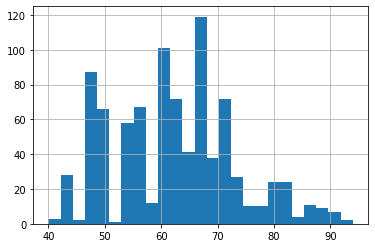

In [345]:
print(candidate.score.hist(bins=25))

In [315]:
candidate.score.describe()

count    895.000000
mean      62.375419
std       10.893108
min       40.000000
25%       54.000000
50%       63.000000
75%       69.000000
max       94.000000
Name: score, dtype: float64

In [13]:
def save_wireshark(df2_protocol,pkl_name,only_one=False):
    '''
    GOAL: save frame time list to pkl for Jerry to output wireshark pcap
    df2_protocol: protocol original dataframe (session-based)
    '''
    protocol_thr = df2_protocol.loc[big_dict_sqlmap[idx]]
    # protocol_thr = df2_protocol.loc[80891]  #也可只輸出一個特定sessiono的time frame list就好
    protocol_thr = protocol_thr.session_time_list.tolist()
    if not only_one:
        protocol_thr = [list(x) for x in protocol_thr]
    pickle.dump(obj=protocol_thr,file=open(pickle_dir+str(pkl_name)+'.pkl','wb'))
    print("總共具有的sessions數量:",len(protocol_thr))
# protocol_thr

sql map http

In [277]:
df2_http[df2_http.ip_src == '190.92.5.158'].index

Int64Index([   80890,    80891,    80892,   334327,   334328,   334329,
              334330,   334331,   334332,   334335,
            ...
            49785502, 50037370, 50037371, 50037372, 50290869, 50290870,
            50290871, 50290872, 50290873, 50290874],
           dtype='int64', length=819)

In [278]:
for k,v in big_dict_http.items():
    if 80891 in v:
        print(k)
        break

2394


In [279]:
case1_diagram = df2_http.loc[list(set(big_dict_http[2394]))]
time_lists = case1_diagram.session_time_list.tolist()
time_lists = [list(x) for x in time_lists]
ips = case1_diagram.ip_src.tolist()
countries = case1_diagram.country.tolist()
print(len(countries),len(ips))
# pickle_dir = '/home/antslab/spark_data/pcap_inter/2020_01_10/中華電信/case_pickles/'
pickle.dump(obj=(time_lists,ips,countries),file=open(pickle_dir+'case#1_threetuples.pkl','wb'))

905 905


In [280]:
case1_diagram.ip_src.unique()

array(['103.16.71.248', '117.1.16.131', '190.92.5.158', '109.198.110.234'],
      dtype=object)

#### SAMBA payload

In [333]:
smb_df, smb_df_payload = prepare_df(df2,'smb')
smb_big_dict,smb_loners,smb_score,smb_cluster_score_dict = similarity_compare(smb_df,smb_df_payload,thr=0)
gc.collect()

/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

0

原本總共sessions#: 352131
共有#sessions可分群: 352131 共有#lonerSessions: 0
可分為#群: 2
前三大的cluster key與對應之群集大小
 10       351309
23848       822
Name: 0, dtype: int64
                   0
count       2.000000
mean   176065.500000
std    247831.734418
min       822.000000
25%     88443.750000
50%    176065.500000
75%    263687.250000
max    351309.000000


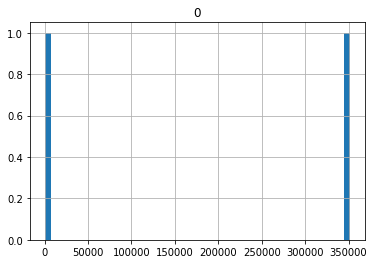

In [337]:
cluster_stat(smb_big_dict,smb_df,drawlog=False)

In [335]:
smb_big_dict = case_cluster_info(smb_loners,smb_big_dict,smb_df,proto='smb') #write to pkl

Unique Country#: 141 Unique IP#: 9056 Session#: 351309
Unique Country#: 30 Unique IP#: 132 Session#: 822


                  0
count  1.454323e+06
mean   1.917936e+01
std    1.130578e+01
min    0.000000e+00
25%    1.366667e+01
50%    2.066667e+01
75%    3.000000e+01
max    1.000000e+02


{100.0: 451,
 92.0: 12,
 75.0: 72,
 52.0: 345,
 50.0: 142,
 49.0: 4,
 44.0: 11,
 43.0: 3,
 38.0: 1,
 37.666666666666664: 6,
 37.333333333333336: 7,
 37.0: 25,
 36.666666666666664: 153,
 36.333333333333336: 204,
 36.0: 131,
 35.666666666666664: 533,
 35.333333333333336: 736,
 35.0: 103,
 34.666666666666664: 686,
 34.333333333333336: 113,
 34.0: 3,
 33.666666666666664: 2,
 33.333333333333336: 346230,
 31.0: 36,
 30.0: 21688,
 27.666666666666668: 22,
 27.333333333333332: 4163,
 26.666666666666668: 315,
 26.333333333333332: 1532,
 25.666666666666668: 68,
 25.0: 69,
 24.666666666666668: 28,
 24.0: 4,
 23.666666666666668: 2,
 23.0: 184,
 22.666666666666668: 24,
 22.0: 47,
 21.666666666666668: 94,
 21.333333333333332: 177318,
 21.0: 149328,
 20.666666666666668: 120858,
 20.333333333333332: 13147,
 20.0: 3745,
 19.666666666666668: 112,
 19.333333333333332: 155658,
 19.0: 5836,
 18.666666666666668: 3273,
 18.333333333333332: 5562,
 18.0: 5351,
 17.666666666666668: 366,
 17.333333333333332: 2218

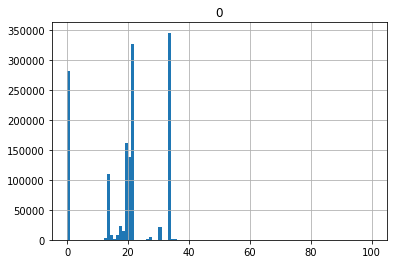

In [336]:
temp = pd.DataFrame(smb_score)
temp.hist(bins=100)
print(temp.describe())
temp = dict(Counter(smb_score))
{k: v for k, v in sorted(temp.items(), key=lambda item: item[0],reverse=True)}

In [288]:
# big_dict_smb[512421] #KeyError

# for k,v in big_dict_smb.items():
#     if 512421 in v:
#         print(k)
#         break

KeyError: 512421

In [293]:
# case2_diagram = df2_smb.loc[list(set(big_dict_smb[10]))]
# time_lists = case2_diagram.session_time_list.tolist()
# time_lists = [list(x) for x in time_lists]
# ips = case2_diagram.ip_src.tolist()
# countries = case2_diagram.country.tolist()
# print(len(set(countries)),len(set(ips)))
# # pickle_dir = '/home/antslab/spark_data/pcap_inter/2020_01_10/中華電信/case_pickles/'
# pickle.dump(obj=(time_lists,ips,countries),file=open(pickle_dir+'case#2_threetuples.pkl','wb'))

141 9056


#### Functionize

* 改成pool

telnet

In [321]:
telnet_df, telnet_df_payload = prepare_df(df2,'telnet')
telnet_big_dict,telnet_loners,telnet_score,telnet_cluster_score_dict = similarity_compare(telnet_df,telnet_df_payload,thr=0)
gc.collect()

/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

55152

原本總共sessions#: 206
共有#sessions可分群: 206 共有#lonerSessions: 0
可分為#群: 7
前三大的cluster key與對應之群集大小
 170578     98
336613     65
6089291    14
773880     12
6592952     9
Name: 0, dtype: int64
               0
count   7.000000
mean   29.428571
std    37.012868
min     4.000000
25%     6.500000
50%    12.000000
75%    39.500000
max    98.000000


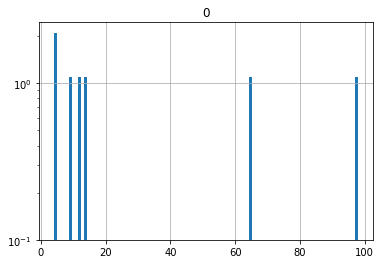

In [331]:
cluster_stat(telnet_big_dict,telnet_df,drawlog=True)

In [324]:
telnet_big_dict = case_cluster_info(telnet_loners,telnet_big_dict,telnet_df,proto='telnet') #write to pkl

Unique Country#: 1 Unique IP#: 10 Session#: 98
Unique Country#: 2 Unique IP#: 4 Session#: 65
Unique Country#: 2 Unique IP#: 5 Session#: 14
Unique Country#: 5 Unique IP#: 9 Session#: 12
Unique Country#: 2 Unique IP#: 5 Session#: 9
Unique Country#: 2 Unique IP#: 3 Session#: 4
Unique Country#: 2 Unique IP#: 3 Session#: 4


                 0
count  1491.000000
mean     46.725017
std      48.872590
min       0.000000
25%       0.000000
50%       0.000000
75%     100.000000
max     100.000000


{100.0: 615,
 99.0: 1,
 97.0: 24,
 96.0: 4,
 86.0: 2,
 85.0: 7,
 83.0: 8,
 82.0: 7,
 80.0: 10,
 79.0: 12,
 77.0: 5,
 72.0: 1,
 50.0: 19,
 20.0: 4,
 13.0: 2,
 12.0: 2,
 10.0: 4,
 9.5: 1,
 8.5: 1,
 8.0: 1,
 0.0: 761}

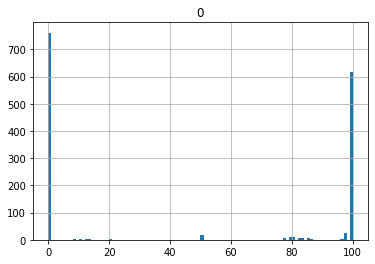

In [330]:
temp = pd.DataFrame(telnet_score)
temp.hist(bins=100)
print(temp.describe())
temp = dict(Counter(telnet_score))
{k: v for k, v in sorted(temp.items(), key=lambda item: item[0],reverse=True)}

In [125]:
# write2pkl(telnet_df,telnet_big_dict,170578,"telnet_1")
# write2pkl(telnet_df,telnet_big_dict,336613,"telnet_2")
# write2pkl(telnet_df,telnet_big_dict,6089291,"telnet_3")


Unique Country#: 1 Unique IP#: 10 Session#: 98
Unique Country#: 2 Unique IP#: 4 Session#: 65
Unique Country#: 2 Unique IP#: 5 Session#: 14


In [302]:
telnet_df[telnet_df.ip_src == '184.154.47.2']

,session_time,session_time_list,session_duration,session_tt_packet,session_i_tt_packet,session_o_tt_packet,session_tt_frame_length,session_i_tt_frame_length,session_o_tt_frame_length,udp_tt_length,udp_i_tt_length,udp_o_tt_length,udp_i_avg_length,udp_o_avg_length,icmp_i_avg_length,icmp_o_avg_length,icmp_tt_original_datagram_length,icmp_i_tt_datagram_length,icmp_o_tt_datagram_length,icmp_i_avg_datagram_length,icmp_o_avg_datagram_length,tcp_tt_payload_length,tcp_i_tt_payload_length,tcp_o_tt_payload_length,tcp_i_avg_payload_length,tcp_o_avg_payload_length,ip_src,ip_dst,tcp_srcport,tcp_dstport,udp_srcport,udp_dstport,country,city,subdivisions,domain,frame_i_common_protocols,frame_o_common_protocols,frame_i_max_protocols,frame_o_max_protocols,tcp_i_payload_list,tcp_o_payload_list
4323967,1.578657e+09,"[1578656838.646141, 1578656838.646389, 1578656...",15.580751,14,9,5,1543,1170.0,373.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,607.0,580.0,27.0,64.444444,5.40,184.154.47.2,210.242.148.22,60274.0,23.0,NaN,NaN,United States,Milan,Illinois,singlehop.net,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:telnet,eth:ethertype:ip:tcp:telnet,[[6:KvVhWKnfANAIKIZVyfOMDiZce5C/jcwV1OkYVoMRo5...,"[[3:UNT2CIQ7A4fTxx18uZhEn:UgNIrfdxSiEn, 157865..."
6089291,1.578657e+09,"[1578656859.986416, 1578656859.986725, 1578656...",10.429977,9,5,4,784,485.0,299.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,186.0,159.0,27.0,31.800000,6.75,184.154.47.2,210.242.148.22,34096.0,23.0,NaN,NaN,United States,Milan,Illinois,singlehop.net,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:telnet,eth:ethertype:ip:tcp:telnet,[[12:YnT4FLBIhvcKC/gkyVF9ekV9A05fxquQCh+nYM:sT...,"[[3:UNT2CIQ7A4fTxx18uZhEn:UgNIrfdxSiEn, 157865..."
6592952,1.578636e+09,"[1578636262.320167, 1578636263.319424, 1578636...",17.556145,15,10,5,1853,1480.0,373.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,843.0,816.0,27.0,81.600000,5.40,184.154.47.2,210.242.148.18,53990.0,23.0,NaN,NaN,United States,Milan,Illinois,singlehop.net,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:telnet,eth:ethertype:ip:tcp:telnet,[[12:rHXq6xmMRe48Is0+R56Y1awh5UP+/4D7eiMJNkZr1...,"[[3:UNT2CIQ7A4fTxx18uZhEn:UgNIrfdxSiEn, 157863..."
8863854,1.578657e+09,"[1578656831.159723, 1578656832.15703, 15786568...",14.985957,15,10,5,1853,1480.0,373.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,843.0,816.0,27.0,81.600000,5.40,184.154.47.2,210.242.148.22,50922.0,23.0,NaN,NaN,United States,Milan,Illinois,singlehop.net,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:telnet,eth:ethertype:ip:tcp:telnet,[[12:rHXq6xmMRetkIs0+R56Y1awh5UP+/4D7eiMJNkZr1...,"[[3:UNT2CIQ7A4fTxx18uZhEn:UgNIrfdxSiEn, 157865..."
9116585,1.578646e+09,"[1578645820.728886, 1578645821.727919, 1578645...",16.753340,11,7,4,1055,756.0,299.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,317.0,290.0,27.0,41.428571,6.75,184.154.47.2,210.242.149.17,43548.0,23.0,NaN,NaN,United States,Milan,Illinois,singlehop.net,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:telnet,eth:ethertype:ip:tcp:telnet,[[12:Ynf852ccEKC/gkOkOoMReT2VmF9eqSz0uP4:wccEX...,"[[3:UNT2CIQ7A4fTxx18uZhEn:UgNIrfdxSiEn, 157864..."
22241687,1.578646e+09,"[1578645813.079108, 1578645813.079411, 1578645...",15.845175,9,5,4,829,530.0,299.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,231.0,204.0,27.0,40.800000,6.75,184.154.47.2,210.242.149.17,34296.0,23.0,NaN,NaN,United States,Milan,Illinois,singlehop.net,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:telnet,eth:ethertype:ip:tcp:telnet,[[12:rHXq6xmMReT2klIs0+R56Y1awh5UP+/4D7eiMJNkZ...,"[[3:UNT2CIQ7A4fTxx18uZhEn:UgNIrfdxSiEn, 157864..."
30568753,1.578636e+09,"[1578636288.475206, 1578636288.475441, 1578636...",12.050930,9,5,4,784,485.0,299.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,186.0,159.0,27.0,31.800000,6.75,184.154.47.2,210.242.148.18,49816.0,23.0,NaN,NaN,United States,Milan,Illinois,singlehop.net,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tc

In [303]:
find_cluster(telnet_big_dict,43187420)

32297542

In [305]:
write2pkl(telnet_df,telnet_big_dict,32297542,3)

2 2


#### tds

In [89]:
tds_df, tds_df_payload = prepare_df(df2,'tds')
tds_big_dict = similarity_compare(tds_df,tds_df_payload)
len(tds_big_dict.keys()) #10:03:06

/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

29

原本總共sessions#: 2225820
共有#sessions可分群: 2225816 共有#lonerSessions: 4
可分為#群: 29
前三大的cluster key與對應之群集大小
 263     1408535
810      168175
2901     158220
Name: 0, dtype: int64
                  0
count  2.900000e+01
mean   7.675228e+04
std    2.618884e+05
min    2.000000e+00
25%    1.200000e+01
50%    1.520000e+02
75%    1.459300e+04
max    1.408535e+06


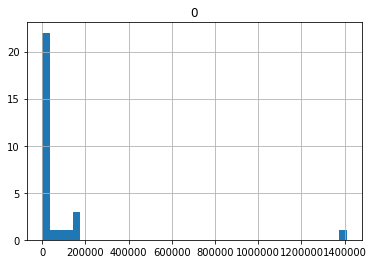

In [126]:
cluster_stat(tds_big_dict,tds_df)

In [127]:
write2pkl(tds_df,tds_big_dict,263,"tds_1")
write2pkl(tds_df,tds_big_dict,810,"tds_2")
write2pkl(tds_df,tds_big_dict,2901,"tds_3")


Unique Country#: 56 Unique IP#: 400 Session#: 1408535
Unique Country#: 78 Unique IP#: 924 Session#: 168175
Unique Country#: 53 Unique IP#: 375 Session#: 158220


In [316]:
tds_df[tds_df.ip_src == '116.98.142.146']

,session_time,session_time_list,session_duration,session_tt_packet,session_i_tt_packet,session_o_tt_packet,session_tt_frame_length,session_i_tt_frame_length,session_o_tt_frame_length,udp_tt_length,udp_i_tt_length,udp_o_tt_length,udp_i_avg_length,udp_o_avg_length,icmp_i_avg_length,icmp_o_avg_length,icmp_tt_original_datagram_length,icmp_i_tt_datagram_length,icmp_o_tt_datagram_length,icmp_i_avg_datagram_length,icmp_o_avg_datagram_length,tcp_tt_payload_length,tcp_i_tt_payload_length,tcp_o_tt_payload_length,tcp_i_avg_payload_length,tcp_o_avg_payload_length,ip_src,ip_dst,tcp_srcport,tcp_dstport,udp_srcport,udp_dstport,country,city,subdivisions,domain,frame_i_common_protocols,frame_o_common_protocols,frame_i_max_protocols,frame_o_max_protocols,tcp_i_payload_list,tcp_o_payload_list
8880,1.578652e+09,"[1578652258.789153, 1578652258.7894, 157865225...",1.208934,8,5,3,732,478.0,254.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,270.0,196.0,74.0,39.200000,24.666667,116.98.142.146,210.242.145.125,39341.0,1433.0,NaN,NaN,Vietnam,Quảng Ngãi,Quảng Ngãi Province,viettel.vn,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:tds:gss-api,eth:ethertype:ip:tcp:tds,[[12:M5YxTvuw3zLw7Ve9VgfY1QWxQtTVGgZA+Oi56imXJ...,[[6:Sf/U/93+uST5O3S3QWi2VfaSCI9uMQy6sd:s/U/B+u...
8893,1.578651e+09,"[1578650551.93434, 1578650551.934552, 15786505...",0.576697,8,5,3,730,476.0,254.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,268.0,194.0,74.0,38.800000,24.666667,116.98.142.146,210.242.145.65,33691.0,1433.0,NaN,NaN,Vietnam,Quảng Ngãi,Quảng Ngãi Province,viettel.vn,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:tds:gss-api,eth:ethertype:ip:tcp:tds,[[12:MdjYxTvuw3zLoyDV33uuEftajiA+Oi56iEvXJ:MC9...,[[6:Sf/U/93+uST5O3S3QWi2VfaSCI9uMQy6sd:s/U/B+u...
8950,1.578648e+09,"[1578647726.148316, 1578647726.148473, 1578647...",1.452684,10,6,4,924,542.0,382.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,342.0,194.0,148.0,32.333333,37.000000,116.98.142.146,210.242.145.65,47653.0,1433.0,NaN,NaN,Vietnam,Quảng Ngãi,Quảng Ngãi Province,viettel.vn,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:tds:gss-api,eth:ethertype:ip:tcp:tds,[[12:MdjYxTvuw3zLoy7xVZABVZeLpCZpCZp9sAPt3ppA+...,[[6:Sf/U/93+uST5O3S3QWi2VfaSCI9uMQy6sd:s/U/B+u...
8956,1.578651e+09,"[1578651049.900827, 1578651049.901286, 1578651...",93.001999,14,8,6,1280,840.0,440.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,458.0,384.0,74.0,48.000000,12.333333,116.98.142.146,210.242.145.65,48028.0,1433.0,NaN,NaN,Vietnam,Quảng Ngãi,Quảng Ngãi Province,viettel.vn,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:tds:gss-api,eth:ethertype:ip:tcp:tds,[[12:M4YxTvuw36GmRpTuKZpVZAaE3YpyoyVfpA+Oi56iE...,[[6:Sf/U/93+uST5O3S3QWi2VfaSCI9uMQy6sd:s/U/B+u...
8959,1.578648e+09,"[1578647865.141733, 1578647865.142038, 1578647...",0.592815,10,6,4,922,540.0,382.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,340.0,192.0,148.0,32.000000,37.000000,116.98.142.146,210.242.145.65,48704.0,1433.0,NaN,NaN,Vietnam,Quảng Ngãi,Quảng Ngãi Province,viettel.vn,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:tds:gss-api,eth:ethertype:ip:tcp:tds,[[12:M4YxTvuw36GmRpJinvhtIJ1VNVQA+Oi56iEvXJ:M9...,[[6:Sf/U/93+uST5O3S3QWi2VfaSCI9uMQy6sd:s/U/B+u...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50218448,1.578653e+09,"[1578652838.658343, 1578652838.658545, 1578652...",0.670841,8,5,3,724,476.0,248.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,268.0,194.0,74.0,38.800000,24.666667,116.98.142.146,210.242.149.123,49321.0,1433.0,NaN,NaN,Vietnam,Quảng Ngãi,Quảng Ngãi Province,viettel.vn,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:tds:gss-api,eth:ethertype:ip:tcp:tds,[[12:MdjYxTvuw36I2OTApieK5xCVtpA+Oi5ac8VlJ:MC9...,[[6:Sf/U/93+uST5O3S3QWi2VfaSCI9uMQy6sd:s/U/B+u...
50218459,1.578653e+09,"[1578652571.62375, 1578652571.623942, 15786525...",149.046448,22,11,11,19

In [317]:
key_ = find_cluster(tds_big_dict,50218448)
write2pkl(tds_df,tds_big_dict,key_,4)

Unique Country#: 35 Unique IP#: 177 Session#: 1335894


#### smtp

In [133]:
smtp_df, smtp_df_payload = prepare_df(df2,'smtp')
smtp_big_dict = similarity_compare(smtp_df,smtp_df_payload)
len(smtp_big_dict.keys()) #10:03:06

/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

30

原本總共sessions#: 14256
共有#sessions可分群: 14232 共有#lonerSessions: 24
可分為#群: 30
前三大的cluster key與對應之群集大小
 28053    11671
73899      735
4033       594
Name: 0, dtype: int64
                  0
count     30.000000
mean     474.400000
std     2121.915215
min        2.000000
25%        8.000000
50%       12.500000
75%       64.750000
max    11671.000000


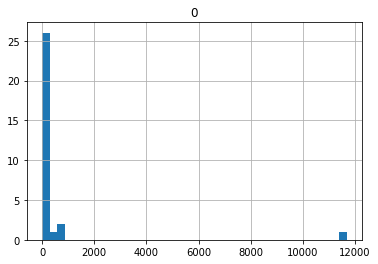

In [134]:
cluster_stat(smtp_big_dict,smtp_df)

In [135]:
write2pkl(smtp_df,smtp_big_dict,28053,"smtp_1")
write2pkl(smtp_df,smtp_big_dict,73899,"smtp_2")
write2pkl(smtp_df,smtp_big_dict,4033,"smtp_3")


Unique Country#: 7 Unique IP#: 21 Session#: 11671
Unique Country#: 3 Unique IP#: 11 Session#: 735
Unique Country#: 8 Unique IP#: 31 Session#: 594


#### FTP

In [326]:
ftp_df, ftp_df_payload = prepare_df(df2,'ftp')
ftp_big_dict,ftp_loners,ftp_score,ftp_cluster_score_dict = similarity_compare(ftp_df,ftp_df_payload,thr=0)
gc.collect()

/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

24300

原本總共sessions#: 7675
共有#sessions可分群: 7671 共有#lonerSessions: 4
可分為#群: 28
前三大的cluster key與對應之群集大小
 2001      5504
3479       855
83203      324
30400      320
969295     112
Name: 0, dtype: int64
                 0
count    28.000000
mean    273.964286
std    1039.340691
min       2.000000
25%       7.750000
50%      27.500000
75%      54.000000
max    5504.000000


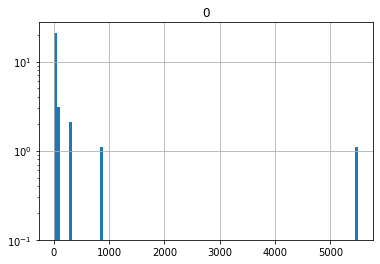

In [332]:
cluster_stat(ftp_big_dict,ftp_df,drawlog=True)

In [328]:
ftp_big_dict = case_cluster_info(ftp_loners,ftp_big_dict,ftp_df,proto='ftp') #write to pkl

Unique Country#: 9 Unique IP#: 42 Session#: 5504
Unique Country#: 7 Unique IP#: 143 Session#: 855
Unique Country#: 3 Unique IP#: 5 Session#: 324
Unique Country#: 23 Unique IP#: 74 Session#: 320
Unique Country#: 9 Unique IP#: 21 Session#: 112
Unique Country#: 7 Unique IP#: 14 Session#: 71
Unique Country#: 4 Unique IP#: 7 Session#: 60
Unique Country#: 1 Unique IP#: 6 Session#: 52
Unique Country#: 1 Unique IP#: 1 Session#: 47
Unique Country#: 10 Unique IP#: 23 Session#: 46
Unique Country#: 3 Unique IP#: 6 Session#: 38
Unique Country#: 1 Unique IP#: 7 Session#: 36
Unique Country#: 3 Unique IP#: 4 Session#: 33
Unique Country#: 7 Unique IP#: 12 Session#: 28
Unique Country#: 1 Unique IP#: 1 Session#: 27
Unique Country#: 1 Unique IP#: 6 Session#: 26
Unique Country#: 2 Unique IP#: 5 Session#: 23
Unique Country#: 1 Unique IP#: 2 Session#: 14
Unique Country#: 3 Unique IP#: 4 Session#: 11
Unique Country#: 6 Unique IP#: 8 Session#: 8
Unique Country#: 1 Unique IP#: 1 Session#: 8
Unique Country#: 2 U

                   0
count  109576.000000
mean        4.588301
std        17.170698
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       100.000000


{100.0: 1886,
 99.0: 3,
 97.0: 5,
 96.0: 2,
 94.0: 26,
 93.0: 46,
 91.0: 9,
 90.0: 1,
 60.0: 4,
 56.0: 1,
 52.0: 1,
 50.0: 5747,
 44.0: 1,
 43.0: 3,
 42.5: 1,
 41.5: 10,
 41.0: 9,
 40.0: 1,
 39.5: 1,
 35.0: 66,
 33.333333333333336: 377,
 16.0: 3,
 14.0: 4,
 13.0: 6,
 11.0: 64,
 10.0: 3,
 7.5: 3,
 7.0: 20,
 6.5: 15,
 6.0: 9,
 5.0: 37,
 4.333333333333333: 114,
 0.0: 101098}

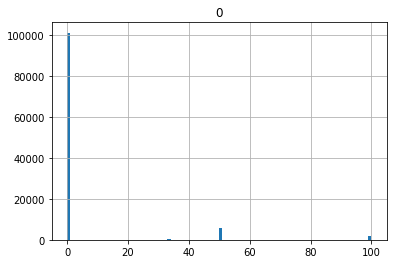

In [329]:
temp = pd.DataFrame(ftp_score)
temp.hist(bins=100)
print(temp.describe())
temp = dict(Counter(ftp_score))
{k: v for k, v in sorted(temp.items(), key=lambda item: item[0],reverse=True)}

### sip

/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

原本總共sessions#: 5173
共有#sessions可分群: 5171 共有#lonerSessions: 2
可分為#群: 4
前三大的cluster key與對應之群集大小
 168648    4738
27198      280
268847     139
Name: 0, dtype: int64
                 0
count     4.000000
mean   1292.750000
std    2299.402151
min      14.000000
25%     107.750000
50%     209.500000
75%    1394.500000
max    4738.000000


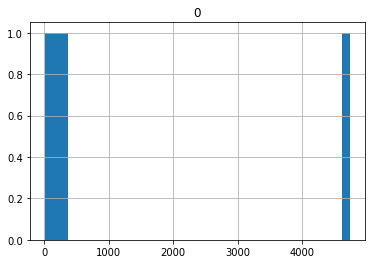

In [139]:
sip_df, sip_df_payload = prepare_df(df2,'sip')
sip_big_dict = similarity_compare(sip_df,sip_df_payload)
cluster_stat(sip_big_dict,sip_df)

In [140]:
write2pkl(sip_df,sip_big_dict,168648,"sip_1")
write2pkl(sip_df,sip_big_dict,27198,"sip_2")
write2pkl(sip_df,sip_big_dict,268847,"sip_3")


Unique Country#: 1 Unique IP#: 1 Session#: 4738
Unique Country#: 2 Unique IP#: 49 Session#: 280
Unique Country#: 1 Unique IP#: 2 Session#: 139


#### Mysql

/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

原本總共sessions#: 1033
共有#sessions可分群: 621 共有#lonerSessions: 412
可分為#群: 6
前三大的cluster key與對應之群集大小
 83156       413
11939584     67
1725770      55
43979315     53
26070610     22
Name: 0, dtype: int64
                0
count    6.000000
mean   103.500000
std    153.116622
min     11.000000
25%     29.750000
50%     54.000000
75%     64.000000
max    413.000000


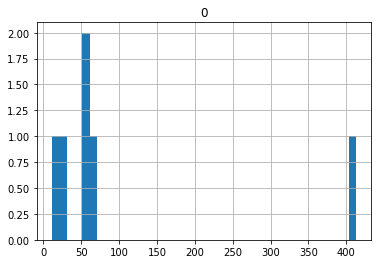

In [61]:
mysql_df, mysql_df_payload = prepare_df(df2,'mysql',split='size')
mysql_big_dict,mysql_loner,mysql_score = similarity_compare(mysql_df,mysql_df_payload,thr=80)
cluster_stat(mysql_big_dict,mysql_df)

                  0
count  24096.000000
mean      16.012568
std       20.456599
min        0.000000
25%        0.000000
50%        0.000000
75%       33.333333
max      100.000000


Counter({0.0: 12865,
         33.333333333333336: 6941,
         5.333333333333333: 430,
         26.333333333333332: 129,
         26.0: 82,
         12.666666666666666: 36,
         17.333333333333332: 65,
         25.0: 29,
         19.333333333333332: 67,
         25.666666666666668: 98,
         26.666666666666668: 93,
         27.333333333333332: 38,
         18.0: 39,
         19.0: 59,
         24.666666666666668: 38,
         16.0: 12,
         16.666666666666668: 11,
         11.0: 3,
         100.0: 474,
         27.0: 147,
         32.0: 412,
         29.0: 280,
         30.0: 1,
         45.0: 4,
         21.333333333333332: 571,
         8.333333333333334: 53,
         18.333333333333332: 73,
         20.666666666666668: 2,
         20.0: 30,
         16.333333333333332: 15,
         21.666666666666668: 4,
         18.666666666666668: 1,
         23.666666666666668: 1,
         22.0: 2,
         24.5: 22,
         27.5: 87,
         50.0: 367,
         28.5: 21,
         

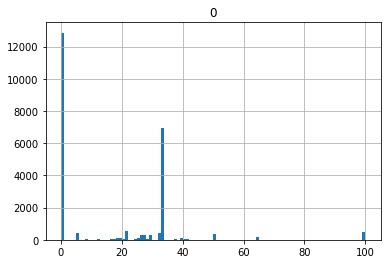

In [60]:
temp = pd.DataFrame(mysql_score)
temp.hist(bins=100)
print(temp.describe())
Counter(mysql_score)

In [62]:
write2pkl(mysql_df,mysql_big_dict,83156,"mysql_1")
write2pkl(mysql_df,mysql_big_dict,11939584,"mysql_2")
write2pkl(mysql_df,mysql_big_dict,1725770,"mysql_3")


Unique Country#: 3 Unique IP#: 3 Session#: 413
Unique Country#: 1 Unique IP#: 1 Session#: 67
Unique Country#: 1 Unique IP#: 1 Session#: 55


In [143]:
pickle.dump(obj=(http_big_dict,smb_big_dict,telnet_big_dict,tds_big_dict,smtp_big_dict,ftp_big_dict,
                 sip_big_dict,mysql_big_dict),file=open(pickle_dir+"allProtocol_case_dict.pkl",'wb'))

# Deprecated
* old original function

In [69]:
def build_matrix(sessions_payload,idxes):
    '''
    sessions_payload: list of lists (hashes)
    idxes: list (corresponding Index)
    
    Return: dictionry=> key=idx,value=list of tuples (idx_compare,final_session_score)
    '''
    sessions_num = len(sessions_payload)
    assert  sessions_num == len(idxes)
    big_dict = {}
    all_scores = []
    for i,(packets_payload,idx) in tqdm(enumerate(zip(sessions_payload,idxes))):
        packets_num = len(packets_payload)
        q1 = int(packets_num/4)
        q2 = int(packets_num/2)
        q3 = int(packets_num*0.75)
        
        tryq1 = packets_payload[q1]
        tryq1_split = tryq1.split(':')
        q1len_segment = tryq1_split[0]
        q1len_payload = ":".join(tryq1_split[1:])        
        if q1 == q2 == q3:
            flag=False
        else:
            tryq2 = packets_payload[q2]
            tryq2_split = tryq2.split(':')
            q2len_segment = tryq2_split[0]
            q2len_payload = ":".join(tryq2_split[1:])
            
            tryq3 = packets_payload[q3]
            tryq3_split = tryq3.split(':')
            q3len_segment = tryq3_split[0]
            q3len_payload = ":".join(tryq3_split[1:])            
            flag = True

        final_li = []
        for j in range(sessions_num-i-1): #往下比
            idx_compare = j+i+1
            session_payload_compare = sessions_payload[idx_compare]
            session_score = []
            for packet_payload_compare in session_payload_compare: #packet_payload_compare == '6:rHKAqEDxghMRo5auSGy6A7WfXl3Nupfh/aEjmjmn:rHXq6xmMRe9SNYV3NkZr8m'                
                test_segment = packet_payload_compare.split(':')[0]
                if test_segment == q1len_segment:
                    scoreq1 = ssdeep.compare(tryq1,packet_payload_compare)
                else:
                    scoreq1 = 0
                if flag:
                    if test_segment == q2len_segment:
                        scoreq2 = ssdeep.compare(tryq2,packet_payload_compare)
                    else:
                        scoreq2 = 0
                    if test_segment == q3len_segment:
                        scoreq3 = ssdeep.compare(tryq3,packet_payload_compare)
                    else:
                        scoreq3 = 0
                    if scoreq1 == scoreq2 == scoreq3 <1:
                        min_packet = packets_payload[0]
                        max_packet = packets_payload[-1]
                        scoreMin = 0
                        scoreMax = 0
                        if min_packet.split(':')[0] == test_segment:
                            scoreMin = ssdeep.compare(min_packet,packet_payload_compare) #第一個時間得比較
                        if max_packet.split(':')[0] == test_segment:
                            scoreMax = ssdeep.compare(max_packet,packet_payload_compare) #最後一個時間得比較
                        session_score.append(max(scoreMin,scoreMax))
                        continue
                session_score.append(max(scoreq1,scoreq2,scoreq3))
            final_score = max(session_score)
            if final_score>0:
                final_li.append((idxes[idx_compare],final_score))
                all_scores.append(final_score) #統計用
        big_dict[idx] = final_li
    return big_dict,all_scores
#                 test_split = packet_payload_compare.split(':')
#                 test_segment = test_split[0]
#                 if 

In [93]:
%%time
def build_matrix_mu(sessions_payload,idxes):
    '''
    sessions_payload: list of lists (hashes)
    idxes: list (corresponding Index)
    
    Return: dictionry=> key=idx,value=list of tuples (idx_compare,final_session_score)
    '''
    sessions_num = len(sessions_payload)
    assert  sessions_num == len(idxes)
    inputs = [(i,x,y) for i,(x,y) in enumerate(zip(sessions_payload,idxes))]
    
    
#     all_scores = []
def func(param):#i,(packets_payload,idx) in tqdm(enumerate(zip(sessions_payload,idxes))):
    i,packets_payload,idx = param
    big_dict = {}
    packets_num = len(packets_payload)
    q1 = int(packets_num/4)
    q2 = int(packets_num/2)
    q3 = int(packets_num*0.75)

    tryq1 = packets_payload[q1]
    tryq1_split = tryq1.split(':')
    q1len_segment = tryq1_split[0]
    q1len_payload = ":".join(tryq1_split[1:])        
    if q1 == q2 == q3:
        flag=False
    else:
        tryq2 = packets_payload[q2]
        tryq2_split = tryq2.split(':')
        q2len_segment = tryq2_split[0]
        q2len_payload = ":".join(tryq2_split[1:])

        tryq3 = packets_payload[q3]
        tryq3_split = tryq3.split(':')
        q3len_segment = tryq3_split[0]
        q3len_payload = ":".join(tryq3_split[1:])            
        flag = True

    final_li = []
    for j in range(sessions_num-i-1): #往下比
        idx_compare = j+i+1
        session_payload_compare = sessions_payload[idx_compare]
        session_score = []
        for packet_payload_compare in session_payload_compare: #packet_payload_compare == '6:rHKAqEDxghMRo5auSGy6A7WfXl3Nupfh/aEjmjmn:rHXq6xmMRe9SNYV3NkZr8m'                
            test_segment = packet_payload_compare.split(':')[0]
            scoreq1 = scoreq2 = scoreq3 = 0
            if test_segment == q1len_segment:
                scoreq1 = ssdeep.compare(tryq1,packet_payload_compare)
#             else:
#                 scoreq1 = 0
            if flag:
#                 scoreq2 = 0
                if test_segment == q2len_segment:
                    scoreq2 = ssdeep.compare(tryq2,packet_payload_compare)
#                 else:
#                     scoreq2 = 0
#                 scoreq3 = 0
                if test_segment == q3len_segment:
                    scoreq3 = ssdeep.compare(tryq3,packet_payload_compare)
#                 else:
#                     scoreq3 = 0
                if scoreq1 == scoreq2 == scoreq3 <1:
                    min_packet = packets_payload[0]
                    max_packet = packets_payload[-1]
                    scoreMin = scoreMax = 0
#                     scoreMax = 0
                    if min_packet.split(':')[0] == test_segment:
                        scoreMin = ssdeep.compare(min_packet,packet_payload_compare) #第一個時間得比較
                    if max_packet.split(':')[0] == test_segment:
                        scoreMax = ssdeep.compare(max_packet,packet_payload_compare) #最後一個時間得比較
                    session_score.append(max(scoreMin,scoreMax))
                    continue
            session_score.append(max(scoreq1,scoreq2,scoreq3))
        final_score = max(session_score)
        if final_score>0:
            final_li.append((idxes[idx_compare],final_score))
#             all_scores.append(final_score) #統計用
    big_dict[idx] = final_li

#         pool = Pool()
inputs = [(i,x,y) for i,(x,y) in enumerate(zip(session_payload,df2_http.index))]
sessions_num = len(session_payload)
sessions_payload=session_payload
idxes = df2_http.index
pool = Pool()
start = time.time()
out_li = pool.map(func,inputs)
end = time.time()
# with mp.Manager() as manager:
#     big_dict = manager.dict()
#     with manager.Pool() as pool:
#         pool.map(func, inputs) #(sessions_num,i,sessions_payload,q1len_segment,tryq1,q2len_segment,tryq2,q3len_segment,
            #tryq3,packets_payload)
#     return big_dict#,all_scores

#5h 33min 29s

CPU times: user 17.3 s, sys: 19 s, total: 36.4 s
Wall time: 5h 33min 29s


Process ForkPoolWorker-45:
Process ForkPoolWorker-46:
Process ForkPoolWorker-43:
Process ForkPoolWorker-38:
Process ForkPoolWorker-37:
Process ForkPoolWorker-47:
Process ForkPoolWorker-42:
Process ForkPoolWorker-39:
Process ForkPoolWorker-44:
Process ForkPoolWorker-40:
Process ForkPoolWorker-41:
Process ForkPoolWorker-36:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


In [109]:

def similarity_compare_mu(df2_protocol,df2_protocol_payload,thr=40,nprocs=12):
    '''
    GOAL: Multi-preocessing a function.
    df2_protocol: protocol original dataframe (session-based)
    df2_protocol_payload: protocol payload dataframe (packet-based)
    
    Return: dictionary with each cluster 
    '''
    def ssdeep_compare(target_hash,candidate_df):
        '''
        Input1: string of hash
        Input2: dataframe of candidate
        '''
        def compare(candidate_hash):
            return ssdeep.compare(target_hash,candidate_hash)
        return candidate_df.hash.map(compare)
#     big_dict_protocol = {}
#     for idx in tqdm(df2_protocol.index):
#         if idx in used_idx_li:
#             continue
        
    def main_compare(idx,out_q):
        big_dict_protocol = {}
        target = df2_protocol_payload[df2_protocol_payload.idx == idx]
        target = target.reset_index(drop=True)
        t_len = len(target)
        q1 = int(t_len*0.25)
        q2 = int(t_len*0.5)
        t_q1 = target.iloc[q1,-1]
        candidate = df2_protocol_payload[df2_protocol_payload.idx>idx]
        candidate['idx'] = candidate.idx.astype(str)
        candidate_q1 = candidate[candidate['size']==target.iloc[q1,-2]]
        candidate['q1'] = ssdeep_compare(t_q1,candidate_q1)
        if q2 != q1:
            t_q2 = target.iloc[q2,-1]
            q3 = int(t_len*0.75)
            candidate_q2 = candidate[candidate['size']==target.iloc[q2,-2]]
            candidate['q2'] = ssdeep_compare(t_q2,candidate_q2)
            if q3 != q2:
                t_q3 = target.iloc[q3,-1]
                candidate_q3 = candidate[candidate['size']==target.iloc[q3,-2]]
                candidate['q3'] = ssdeep_compare(t_q3,candidate_q3)
        candidate = candidate.drop(['size','hash'],axis=1)
        candidate['score'] = candidate.max(axis=1)
        candidate = candidate[candidate.score>=thr] #相似度分數，數字越小速度愈快、數字越大越多群
        candidate['idx'] = candidate.idx.astype(int)
        idx_li = candidate.idx.tolist()
        if len(idx_li)>0:
            big_dict_protocol[idx] = idx_li
#             used_idx_li.extend(idx_li)
#             used_idx_li = list(set(used_idx_li))
        out_q.put(big_dict_protocol)#return big_dict_protocol
#     with Manager() as manager:
#     used_idx_li = manager.list()
    out_q = mp.Queue()
    
#         big_dict_protocol = manager.dict()
    procs = []
    idx_li = df2_protocol.index.tolist()
    chunksize = int(math.ceil(len(idx_li) / float(nprocs)))
#     for idx in df2_protocol.index:
        
    for i in range(nprocs):
        p = mp.Process(target=main_compare,args=(idx_li[chunksize*i:chunksize*(i+1)],out_q))
        procs.append(p)
        p.start()
#     for idx in tqdm(df2_protocol.index):
#         if idx in used_idx_li:
#             continue
#         p = Process(target=main_compare, args=(used_idx_li,idx,big_dict_protocol))
#         p.start()
#         time.sleep(0.5)
#         processes.append(p)
    resultdict = {}    
    for i in range(nprocs):
        resultdict.update(out_q.get())
    for p in procs:
#         time.sleep(0.5)
        p.join()
    return resultdict#big_dict_protocol